# Project 4: West Nile Virus Prediction

Authors: Cheong Hao Han, Phua Jia Qing, Choo Wende

--------

## Content

**Part 1: Data Cleaning and Processing**
<br>
_(Project_4_Part1_WJH.ipynb)_
1. Weather Data
2. Spray Data
3. Train and Test Data
4. Merge and Save DataFrame

**Part 2: Exploratory Data Analysis**
<br>
_(Project_4_Part2_WJH.ipynb)_
1. Map Overview of Data
2. Train Data Analysis
3. Weather Data Analysis
4. Spray Data Analysis

**Part 3: Modelling**
<br>
_(Project_4_Part3_WJH.ipynb)_
1. Preprocessing
2. Modelling
3. Model Comparison
4. Kaggle Submission
5. Cost-Benefit Analysis
6. Conclusion & Recommendations


## Libraries

In [1]:
#pip install geopy

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime, date
from geopy.distance import geodesic

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, \
accuracy_score, recall_score, precision_score, f1_score, silhouette_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## Part 2: Exploratory Data Analysis

In [3]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Import Data

In [4]:
# use when running from colab
PATH = '/content/drive/MyDrive/DSI30/'

# use when running on local machine
# PATH = '../'

In [5]:
# Import Train/Test merged and spray dataset
train_merged = pd.read_csv(f'{PATH}data/train_merged.csv')
test_merged = pd.read_csv(f'{PATH}data/test_merged.csv')

spray_df = pd.read_csv(f'{PATH}data/spray_cleaned.csv')

In [6]:
# Verify Dataframe info
train_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Date          10415 non-null  object 
 1   Address       10415 non-null  object 
 2   Species       10415 non-null  object 
 3   Trap          10415 non-null  object 
 4   Latitude      10415 non-null  float64
 5   Longitude     10415 non-null  float64
 6   NumMosquitos  10415 non-null  int64  
 7   WnvPresent    10415 non-null  int64  
 8   Year          10415 non-null  int64  
 9   Month         10415 non-null  int64  
 10  Day           10415 non-null  int64  
 11  Week          10415 non-null  int64  
 12  Station       10415 non-null  int64  
 13  Tmax          10415 non-null  int64  
 14  Tmin          10415 non-null  int64  
 15  Tavg          10415 non-null  float64
 16  DewPoint      10415 non-null  int64  
 17  WetBulb       10415 non-null  float64
 18  Heat          10415 non-nu

In [7]:
# Verify Dataframe info
test_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 116293 entries, 0 to 116292
Data columns (total 27 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Id           116293 non-null  int64  
 1   Date         116293 non-null  object 
 2   Address      116293 non-null  object 
 3   Species      116293 non-null  object 
 4   Trap         116293 non-null  object 
 5   Latitude     116293 non-null  float64
 6   Longitude    116293 non-null  float64
 7   Year         116293 non-null  int64  
 8   Month        116293 non-null  int64  
 9   Day          116293 non-null  int64  
 10  Week         116293 non-null  int64  
 11  Station      116293 non-null  int64  
 12  Tmax         116293 non-null  int64  
 13  Tmin         116293 non-null  int64  
 14  Tavg         116293 non-null  float64
 15  DewPoint     116293 non-null  int64  
 16  WetBulb      116293 non-null  float64
 17  Heat         116293 non-null  float64
 18  Cool         116293 non-

In [8]:
# Verify Dataframe info
spray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13615 entries, 0 to 13614
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         13615 non-null  object 
 1   Time         13615 non-null  object 
 2   Latitude     13615 non-null  float64
 3   Longitude    13615 non-null  float64
 4   Spray Count  13615 non-null  int64  
 5   Year         13615 non-null  int64  
 6   Month        13615 non-null  int64  
 7   Day          13615 non-null  int64  
 8   Week         13615 non-null  int64  
dtypes: float64(2), int64(5), object(2)
memory usage: 957.4+ KB


In [9]:
# Convert date to date-time
train_merged['Date'] = pd.to_datetime(train_merged['Date'])
test_merged['Date'] = pd.to_datetime(test_merged['Date'])
spray_df['Date'] = pd.to_datetime(spray_df['Date'])

## Exploratory Data Analysis

### Map Overview of Data (2007, 2009, 2011, 2013) 

In [10]:
# plot locations of traps and instances of WNV cases
# Instantiating map variables. 
mapdata = np.loadtxt(f'{PATH}/data/mapdata_copyright_openstreetmap_contributors.txt')

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_boundary = (-88, -87.5, 41.6, 42.1)

# plot locations of traps and instances of WNV cases
wnv = train_merged.loc[train_merged["WnvPresent"]==1]
no_wnv = train_merged.loc[train_merged["WnvPresent"]==0]

plt.figure(figsize=(10,14))

plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_boundary, 
           aspect=aspect)

# plot station 1
plt.scatter(-87.933, 
            41.995, 
            c="green", 
            marker='x', 
            s=20, 
            alpha=1, 
            label='Station 1')

# plot station 2
plt.scatter(-87.752, 
            41.786, 
            c="purple", 
            marker='x', 
            s=20, 
            alpha=1, 
            label='Station 2')

# plot spray area
plt.scatter(spray_df['Longitude'], 
            spray_df['Latitude'], 
            c="yellow", 
            s=20, 
            alpha=0.1, 
            label='Spray Area')

# plot no wnv traps
plt.scatter(no_wnv['Longitude'], 
            no_wnv['Latitude'], 
            c="blue", 
            s=40, 
            alpha=1, 
            label='Without Nile Virus')

# plot traps with wnv
plt.scatter(wnv['Longitude'], 
            wnv['Latitude'], 
            c="red", 
            s=15, 
            alpha=1, 
            label='With Nile Virus')

plt.title("Location of Traps in Train Data (2007, 2009, 2011, 2013)", 
          fontsize=15)
plt.legend();

Output hidden; open in https://colab.research.google.com to view.

### Train Data Analysis

In [11]:
# Display Spray area by year on map

# Create sub plots.
fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15,20))
axes=axes.ravel()

for i, yr in enumerate([2007, 2009, 2011, 2013]):
    
    # Plot map
    axes[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_boundary, aspect=aspect)
    
    # Plot without WNV trap
    axes[i].scatter(data=no_wnv[no_wnv['Year']==yr],
                    x='Longitude', 
                    y='Latitude', 
                    c="blue", 
                    s=30, 
                    alpha=1, 
                    label='Without Nile Virus')
    
    # Plot WNV Present trap
    axes[i].scatter(data=wnv[wnv['Year']==yr],
                    x='Longitude', 
                    y='Latitude', 
                    c="red", 
                    s=10, 
                    alpha=1, 
                    label='With Nile Virus')

    axes[i].set_title('Trap Locations in ' + str(yr))
    axes[i].legend()

Output hidden; open in https://colab.research.google.com to view.

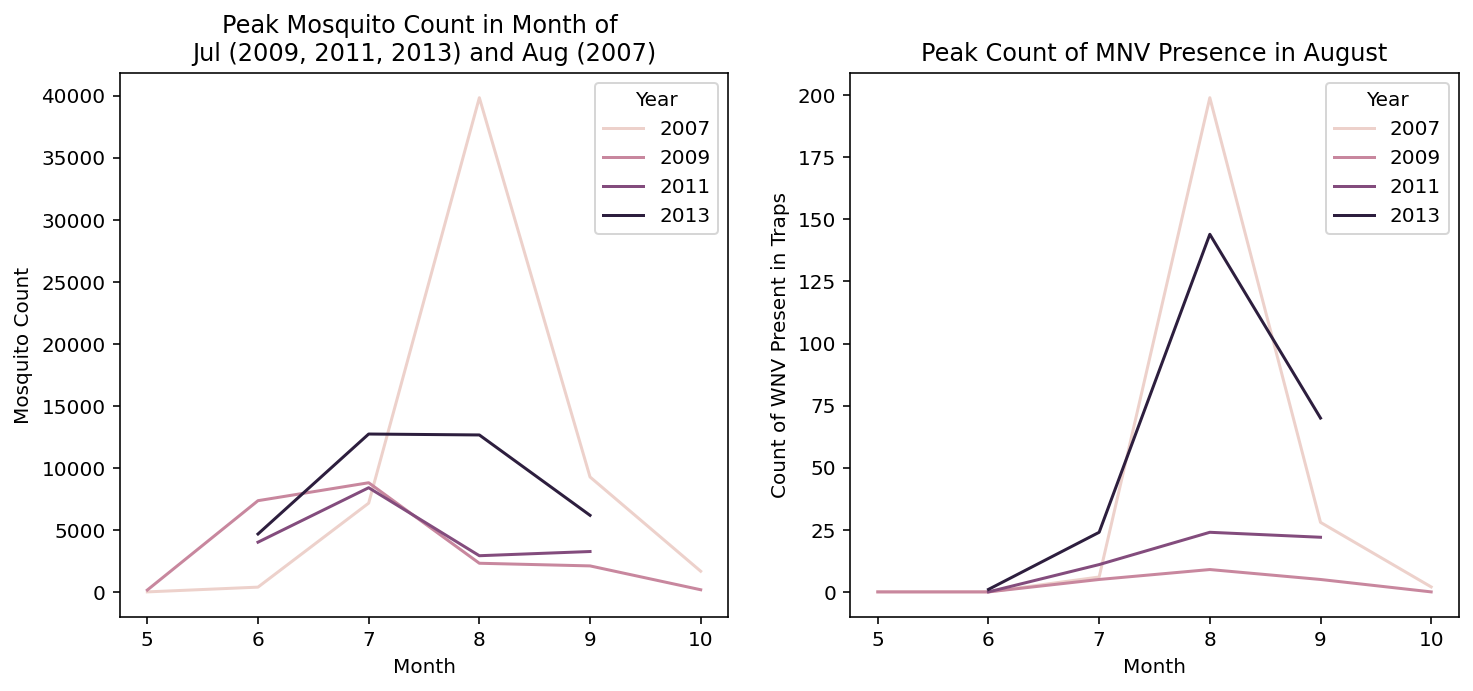

In [12]:
# Plot where sprays have been in the past
mapdata = np.loadtxt(f'{PATH}/data/mapdata_copyright_openstreetmap_contributors.txt')

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

# plot mosquitos/ WnvPresent count by month and year
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=False, figsize=(12,5))
axes=axes.ravel()

# plot WNV occurrences by month and year
sns.lineplot(x='Month', 
             y='NumMosquitos',
             hue='Year', 
             data=train_merged.groupby(by=['Year','Month']).sum()[['NumMosquitos']],
             ax=axes[0],
             ci = None)
axes[0].set_ylabel("Mosquito Count")
axes[0].set_title('Peak Mosquito Count in Month of \nJul (2009, 2011, 2013) and Aug (2007)')

# plot WNV occurrences by month and year
sns.lineplot(x='Month', 
             y='WnvPresent',
             hue='Year', 
             data=train_merged.groupby(by=['Year','Month']).sum()[['WnvPresent']],
             ax=axes[1],
             ci = None)
axes[1].set_ylabel("Count of WNV Present in Traps")
axes[1].set_title('Peak Count of MNV Presence in August')

plt.show()

1. From the location map, it can be seen that WNV is more prevalent in 2007 and 2013. This is also evident in the line plot for WMV Present count.
2. Although the number of mosquitos caught in Aug 2013 is not as high as Aug 2007, it has comparable MNV Presence count as that for Aug 2007. This means that there is a higher proportion of WNV carrying mosquitos in 2013. 
3. It is observed that the occurrence of the WNV in mosquito samples have the highest rates of the virus occurring in August. The rates were highest in 2007, followed by 2013.

In [13]:
#Create dataframe of mosquitos caught on various date. 
mos_dist_df = train_merged.groupby(['Date'])[['NumMosquitos', 'WnvPresent']].sum()
mos_dist_df.head()

NumMosquitos  WnvPresent
Date                                
2007-05-29            40           0
2007-06-05           124           0
2007-06-26           215           0
2007-06-29            84           0
2007-07-02           239           0

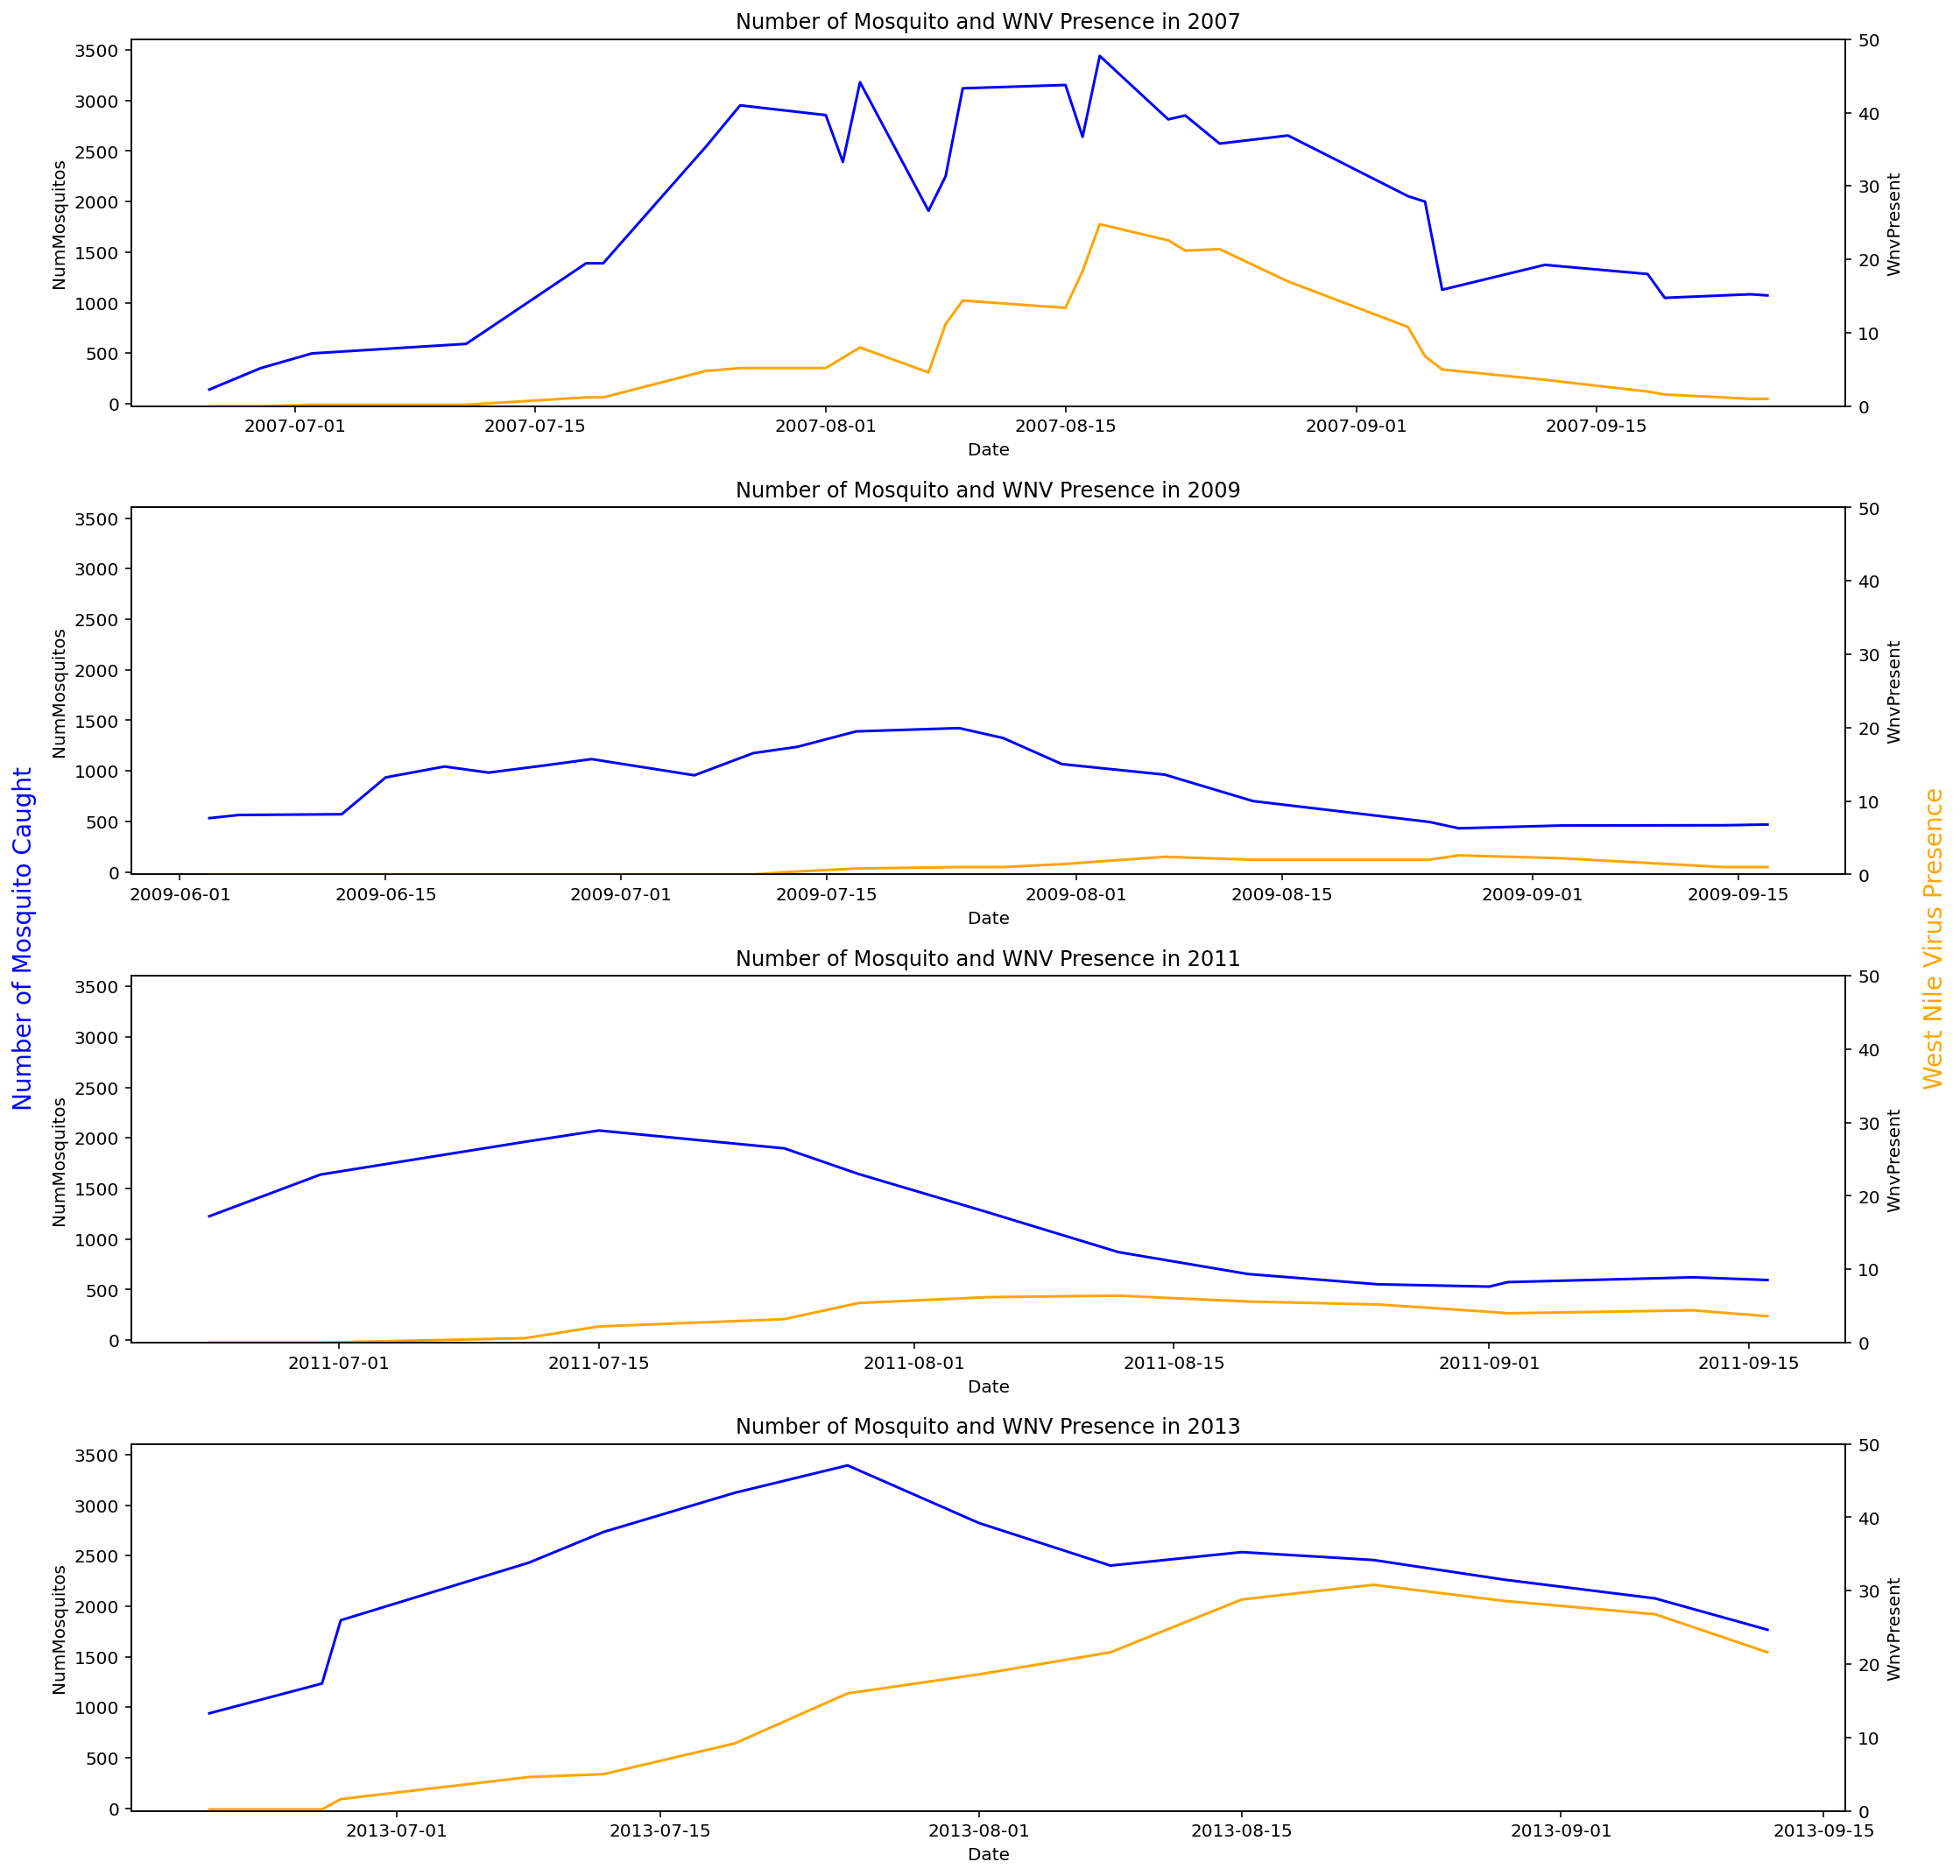

In [14]:
# Plot timeseries of NumMosquitos and WNV Present
fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(15,15), sharey=True)
ax=ax.ravel()

for i, yr in enumerate([2007, 2009, 2011, 2013]):
    ax[i].set_title('Number of Mosquito and WNV Presence in '+ str(yr))
    sns.lineplot(x=mos_dist_df.loc[str(yr)].index,
                 y=mos_dist_df.loc[str(yr)]['NumMosquitos'].rolling(5, center=True).mean(),
                 ax=ax[i], 
                 color='blue')
    ax2=ax[i].twinx()
    sns.lineplot(x=mos_dist_df.loc[str(yr)].index,
                 y=mos_dist_df.loc[str(yr)]['WnvPresent'].rolling(5, center=True).mean(), 
                 ax=ax2,
                 color='orange')
    ax2.set_ylim([0, 50])
fig.text(-0.01, 0.5, 'Number of Mosquito Caught', va='center', rotation='vertical', color='blue', fontsize=14)
fig.text(1, 0.5,  'West Nile Virus Presence', va='center', rotation='vertical', color='orange', fontsize=14)
plt.tight_layout()

1. Based on the plots above, it is observed that mosquitos count starts to increase sharplyaround start of July and WNV presence starts to increase sharply from mid July. 
2. This is likely due to the breeding of WNV carrying mosquitos. 

In [15]:
# Dataframe for top locations with highest number of mosquitos
top_mos_count_df = train_merged.groupby(
    by=['Longitude','Latitude']
).sum()[['NumMosquitos', 'WnvPresent']].sort_values(by='NumMosquitos', 
                                                    ascending=False).head(20)

top_mos_count_df.head()

NumMosquitos  WnvPresent
Longitude  Latitude                           
-87.599862 41.673408         21668          41
-87.890615 41.974689         15386          66
-87.585413 41.726465          9936          16
-87.800991 41.954690          3710          18
-87.565666 41.704572          3315          11

<Figure size 720x720 with 0 Axes>

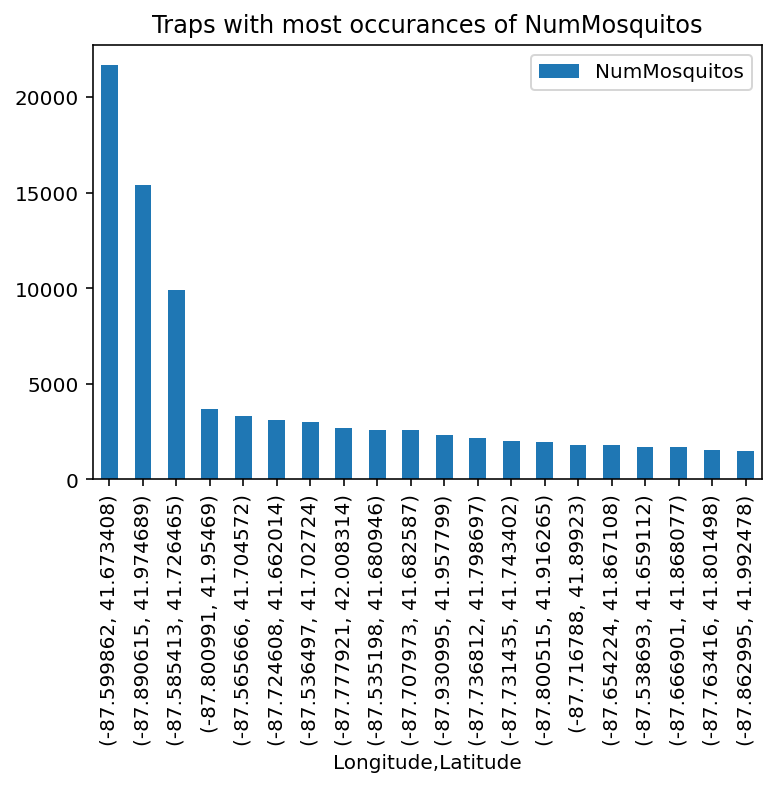

In [16]:
# Plot Distribution of NumMosquitos based on Trap 
plt.figure(figsize=(10, 10));
top_mos_count_df[['NumMosquitos']].plot(kind="bar");
plt.title("Traps with most occurances of NumMosquitos");

In [17]:
# Dataframe for top locations with highest number of WnvPresent
top_wnv_count_df = train_merged.groupby(
    by=['Longitude','Latitude']
).sum()[['NumMosquitos', 'WnvPresent']].sort_values(by='WnvPresent', 
                                                    ascending=False).head(20)

top_wnv_count_df.head()

NumMosquitos  WnvPresent
Longitude  Latitude                           
-87.890615 41.974689         15386          66
-87.599862 41.673408         21668          41
-87.800991 41.954690          3710          18
-87.585413 41.726465          9936          16
-87.757639 41.964242          1346          14

<Figure size 1296x360 with 0 Axes>

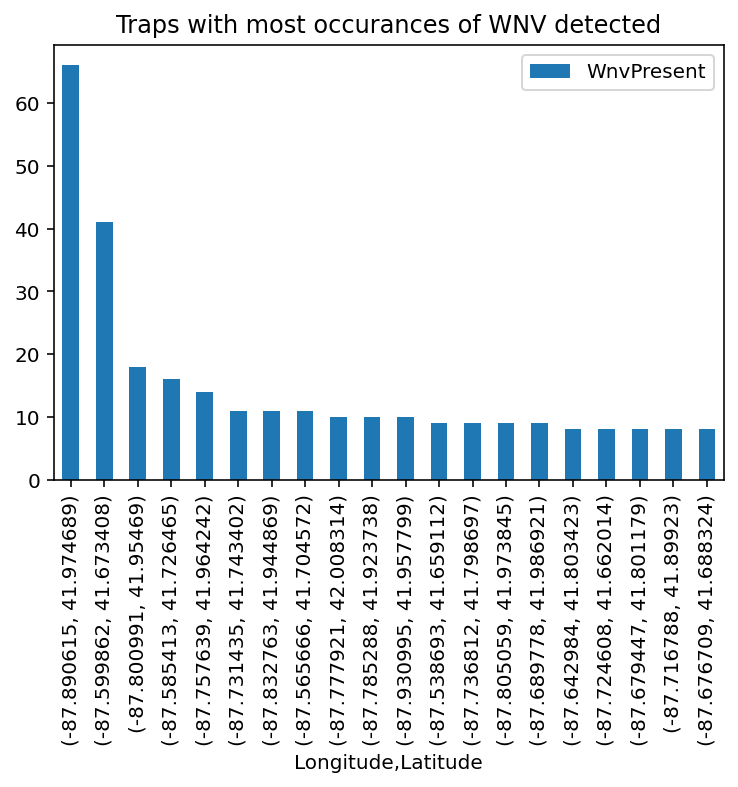

In [18]:
# Plot Distribution of WnvPresent based on Trap 
plt.figure(figsize=(18, 5));
top_wnv_count_df[['WnvPresent']].plot(kind="bar");
plt.title("Traps with most occurances of WNV detected");

In [19]:
# plot locations of traps and instances of WNV cases

plt.figure(figsize=(10,14))

plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_boundary, 
           aspect=aspect)

plt.scatter(top_mos_count_df.index.get_level_values(0), 
            top_mos_count_df.index.get_level_values(1), 
            c="blue", 
            # marker='x', 
            s=40, 
            alpha=1, 
            label='Top Mosquitos Count')

plt.scatter(top_wnv_count_df.index.get_level_values(0), 
            top_wnv_count_df.index.get_level_values(1), 
            c="red", 
            # marker='x', 
            s=15, 
            alpha=1, 
            label='Top WNV Count')

plt.title("Top 20 Mosquitos or MNV Count Locations (2007, 2009, 2011, 2013)", 
          fontsize=15)
plt.legend();

Output hidden; open in https://colab.research.google.com to view.

In [20]:
# Display locations that are top mosquitos and WNV count
# These locations may be of interest to implement mitigations.
top_loc = top_wnv_count_df.index.intersection(top_mos_count_df.index)
top_wnv_count_df.loc[top_loc]

NumMosquitos  WnvPresent
Longitude  Latitude                           
-87.890615 41.974689         15386          66
-87.599862 41.673408         21668          41
-87.800991 41.954690          3710          18
-87.585413 41.726465          9936          16
-87.731435 41.743402          2014          11
-87.565666 41.704572          3315          11
-87.777921 42.008314          2668          10
-87.930995 41.957799          2327          10
-87.538693 41.659112          1699           9
-87.736812 41.798697          2161           9
-87.724608 41.662014          3122           8
-87.716788 41.899230          1802           8

In [21]:
# Number of locations with top mos count and WNV count
len(top_loc)

12

In [22]:
# Show addresses of top 12 locations that are top mosquitos and WNV count
train_merged[['Longitude','Latitude', 'Trap', 'Address']].drop_duplicates().set_index(['Longitude','Latitude']).loc[top_loc]

Trap                                            Address
Longitude  Latitude                                                          
-87.890615 41.974689  T900  ORD Terminal 5, O'Hare International Airport, ...
-87.599862 41.673408  T115                South Doty Avenue, Chicago, IL, USA
-87.800991 41.954690  T002  4100 North Oak Park Avenue, Chicago, IL 60634,...
-87.585413 41.726465  T138        South Stony Island Avenue, Chicago, IL, USA
-87.731435 41.743402  T225  8200 South Kostner Avenue, Chicago, IL 60652, USA
-87.565666 41.704572  T128     2400 East 105th Street, Chicago, IL 60617, USA
-87.777921 42.008314  T008  7000 North Moselle Avenue, Chicago, IL 60646, USA
-87.930995 41.957799  T903            Ohare Court, Bensenville, IL 60106, USA
-87.538693 41.659112  T221     4000 East 130th Street, Chicago, IL 60633, USA
-87.736812 41.798697  T114   5200 South Kolmar Avenue, Chicago, IL 60632, USA
-87.724608 41.662014  T135       4200 West 127th Street, Alsip, IL 60803, USA
-87.716788 41.899230  T030  1000 North Central Park Avenue, Chicago, IL 60...

In [23]:
# Identify traps with high WNV Present but not high NumMosquitos
high_wnv_rate = [trap for trap in top_wnv_count_df.index if trap not in top_loc]
high_wnv_rate_df = train_merged[['Longitude','Latitude', 'Trap', 'Address']].drop_duplicates().set_index(['Longitude','Latitude']).loc[high_wnv_rate]
high_wnv_rate_df = pd.merge(high_wnv_rate_df, top_wnv_count_df.loc[high_wnv_rate], left_index=True, right_index=True)
high_wnv_rate_df

Trap                                            Address  \
Longitude  Latitude                                                             
-87.757639 41.964242  T003      4600 Milwaukee Avenue, Chicago, IL 60630, USA   
-87.832763 41.944869  T011  3600 North Pittsburgh Avenue, Chicago, IL 6063...   
-87.785288 41.923738  T013  6100 West Fullerton Avenue, Chicago, IL 60639,...   
-87.805059 41.973845  T223  5100 North Mont Clare Avenue, Chicago, IL 6065...   
-87.689778 41.986921  T028  5800 North Western Avenue, Chicago, IL 60659, USA   
-87.642984 41.803423  T082    5000 South Union Avenue, Chicago, IL 60609, USA   
-87.679447 41.801179  T061      2200 West 51st Street, Chicago, IL 60609, USA   
-87.676709 41.688324  T086     2200 West 113th Street, Chicago, IL 60643, USA   

                      NumMosquitos  WnvPresent  
Longitude  Latitude                             
-87.757639 41.964242          1346          14  
-87.832763 41.944869          1311          11  
-87.785288 41.923738          1193          10  
-87.805059 41.973845          1281           9  
-87.689778 41.986921          1020           9  
-87.642984 41.803423           892           8  
-87.679447 41.801179           840           8  
-87.676709 41.688324          1312           8

In [24]:
# Create column to analyse proportion of WNV present to NumMosquitos
high_wnv_rate_df['Proportion']=high_wnv_rate_df['WnvPresent']/high_wnv_rate_df['NumMosquitos']
high_wnv_rate_df.sort_values(by=['Proportion'], ascending=False)

Trap                                            Address  \
Longitude  Latitude                                                             
-87.757639 41.964242  T003      4600 Milwaukee Avenue, Chicago, IL 60630, USA   
-87.679447 41.801179  T061      2200 West 51st Street, Chicago, IL 60609, USA   
-87.642984 41.803423  T082    5000 South Union Avenue, Chicago, IL 60609, USA   
-87.689778 41.986921  T028  5800 North Western Avenue, Chicago, IL 60659, USA   
-87.832763 41.944869  T011  3600 North Pittsburgh Avenue, Chicago, IL 6063...   
-87.785288 41.923738  T013  6100 West Fullerton Avenue, Chicago, IL 60639,...   
-87.805059 41.973845  T223  5100 North Mont Clare Avenue, Chicago, IL 6065...   
-87.676709 41.688324  T086     2200 West 113th Street, Chicago, IL 60643, USA   

                      NumMosquitos  WnvPresent  Proportion  
Longitude  Latitude                                         
-87.757639 41.964242          1346          14    0.010401  
-87.679447 41.801179           840           8    0.009524  
-87.642984 41.803423           892           8    0.008969  
-87.689778 41.986921          1020           9    0.008824  
-87.832763 41.944869          1311          11    0.008391  
-87.785288 41.923738          1193          10    0.008382  
-87.805059 41.973845          1281           9    0.007026  
-87.676709 41.688324          1312           8    0.006098

1. The top 12 traps with top NumMosquito count and WMVPresent identified are: 'T115', 'T900', 'T138', 'T002', 'T128', 'T135', 'T008', 'T903', 'T114', 'T225', 'T030', 'T221'.
2. These locations may be of interest to implement mitigations.
3. It is observed that traps T115', 'T900', 'T138', 'T002', 'T128' have the most occurances of WNV detection.
4. For traps T003, T061, T082, while they have low NumMosquitos, they have high WnvPresent. In other words, the mosquitos in these traps have a higher likelihood of carrying WNV. 

In [25]:
# Create Dataframe of species for analysis
# from the train data, only Pipiens or Restuans species mosquitos carry WNV
# Pipiens species mosquitos are more likely to carry WNV than the other species. 
# This is likely due to the high distribution of these species collected.
species_df=train_merged.groupby(by=['Species']).sum()[['NumMosquitos', 'WnvPresent']].reset_index()
species_df = species_df.sort_values(by='NumMosquitos', ascending=False).reset_index(drop=True)
species_df

Species  NumMosquitos  WnvPresent
0  CULEX PIPIENS/RESTUANS         66043         262
1           CULEX PIPIENS         44543         239
2          CULEX RESTUANS         23386          49
3         CULEX TERRITANS           508           0
4        CULEX SALINARIUS           143           0
5         CULEX ERRATICUS             7           0
6          CULEX TARSALIS             7           0

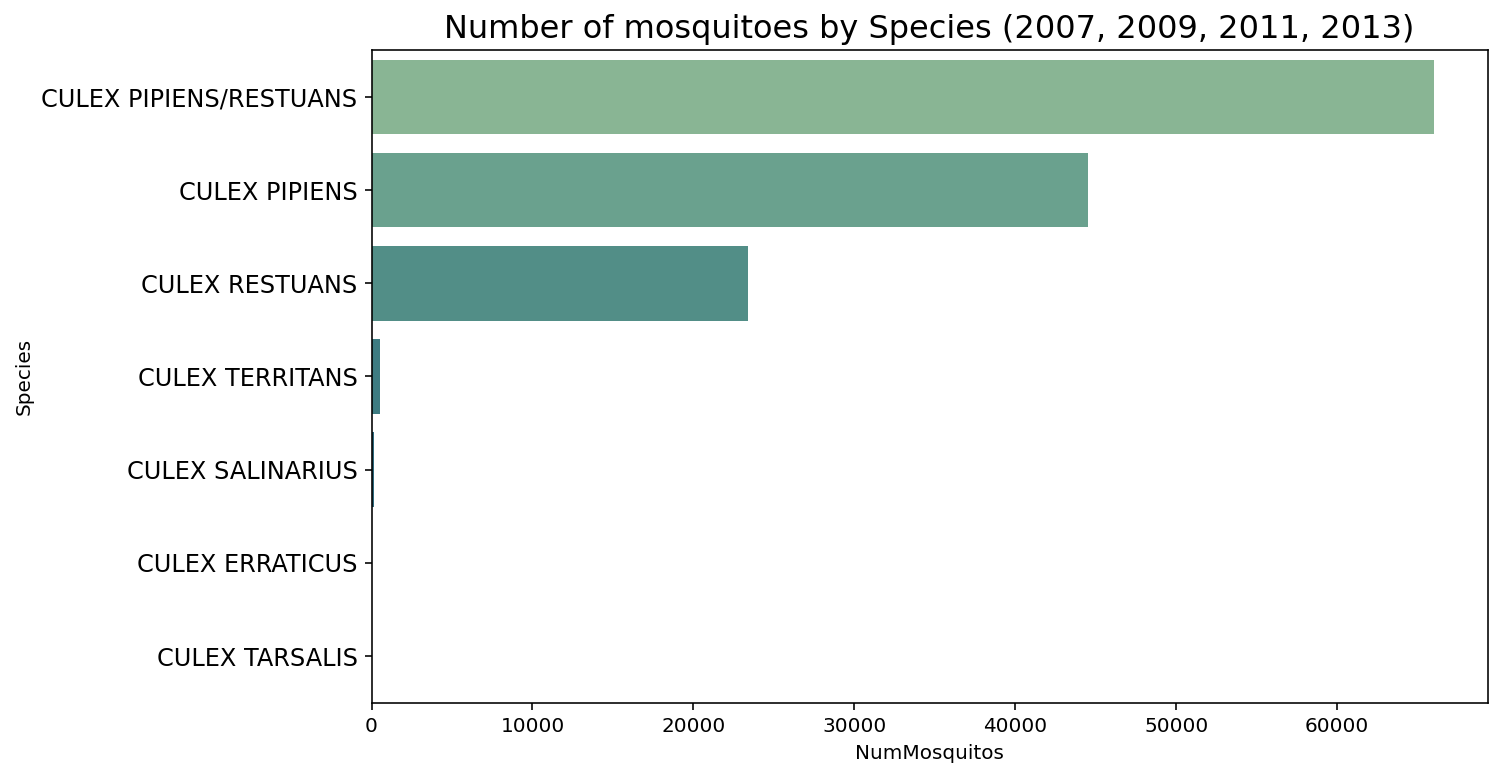

In [26]:
# Plot mosquito count distribution
plt.figure(figsize=(10,6))
ax=sns.barplot(x='NumMosquitos', 
               y='Species',
               data=species_df,
               orient='h', 
               palette='crest');
plt.title('Number of mosquitoes by Species (2007, 2009, 2011, 2013)', fontsize=16);
plt.yticks(fontsize=12);

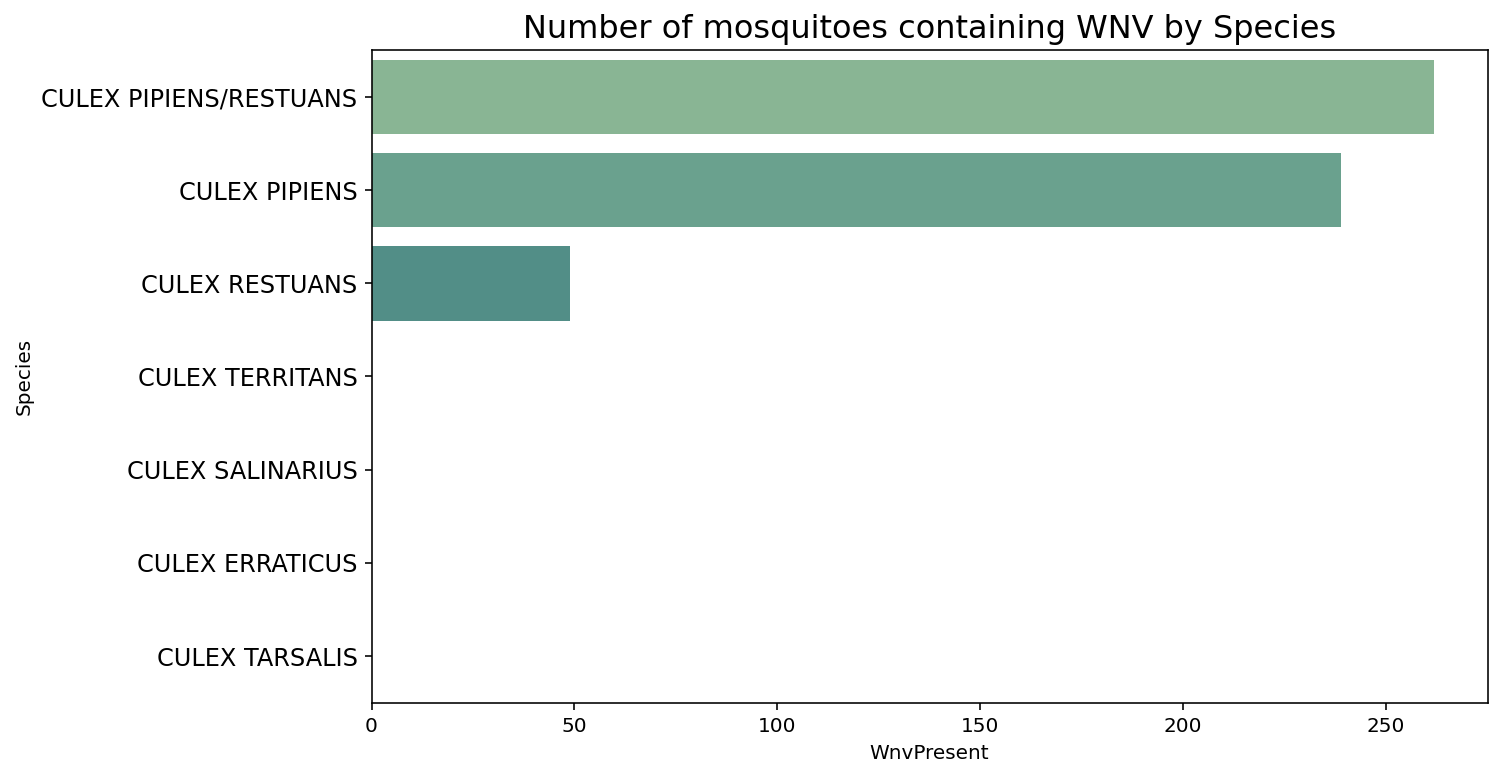

In [27]:
# Plot WnvPresent by Mosquitos Species
plt.figure(figsize=(10,6))
ax=sns.barplot(x='WnvPresent', 
            y='Species',
            data=species_df,
            orient='h', 
            palette='crest');
plt.title('Number of mosquitoes containing WNV by Species', fontsize=16);
plt.yticks(fontsize=12);

1. From the train data, Pipiens and Restuans are the most common species of mosquitos collected. 
2. It is observed that only Pipiens or Restuans species mosquitos carry WNV
3. Pipiens species mosquitos are more likely to carry WNV than the other species. This is likely due to the high distribution of this specie collected.

In [28]:
# Create dataframe for WNW carrying mosquitos
wnv_mos=train_merged.groupby(by=['Year',
                                 'Month',
                                 'Species']).sum()[['NumMosquitos', 'WnvPresent']].reset_index()
wnv_mos=wnv_mos[wnv_mos['WnvPresent']>0]
wnv_mos.head()

Year  Month                 Species  NumMosquitos  WnvPresent
7   2007      7           CULEX PIPIENS          3223           3
8   2007      7  CULEX PIPIENS/RESTUANS          3314           3
12  2007      8           CULEX PIPIENS         25570         123
13  2007      8  CULEX PIPIENS/RESTUANS         13114          70
14  2007      8          CULEX RESTUANS           862           6

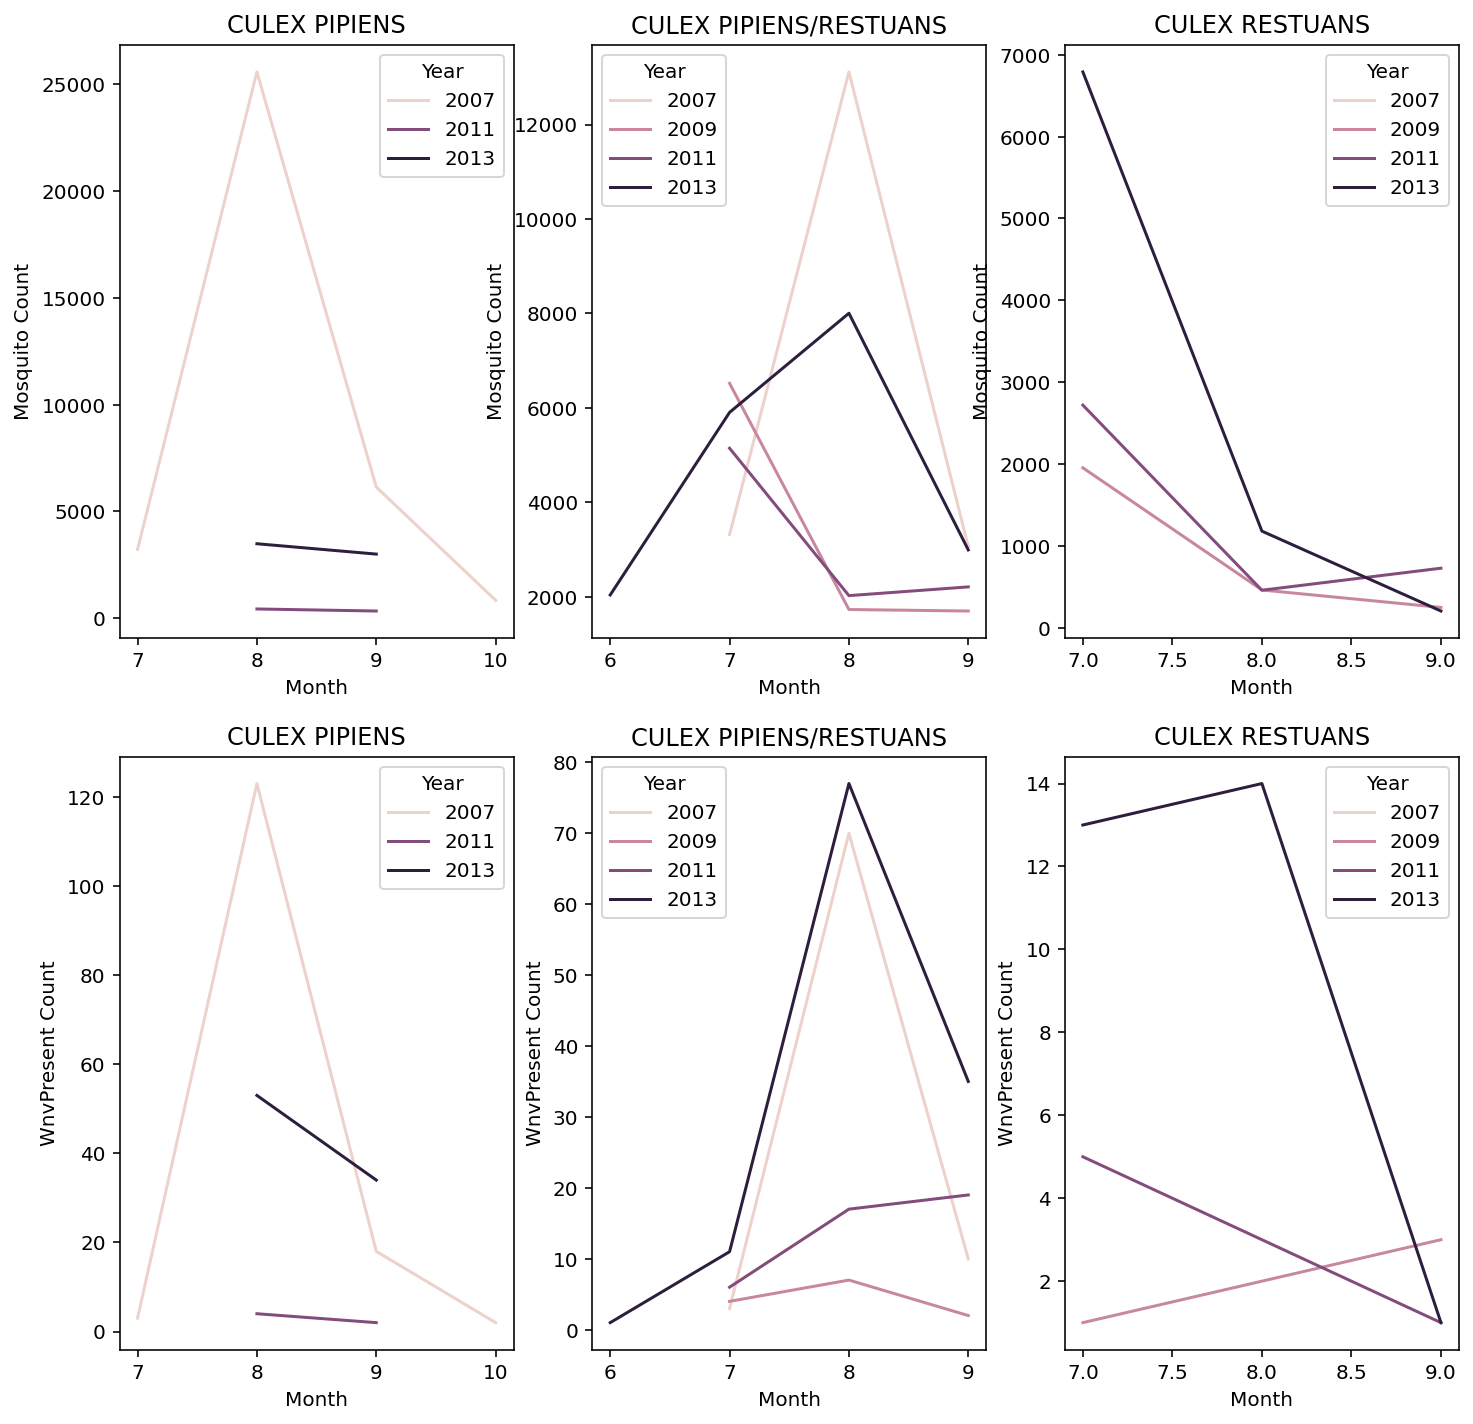

In [29]:
# plot mosquitos/ WnvPresent count by month and year 
# to understand the distribution of mosquito count by specied against time. 
fig, axes = plt.subplots(nrows=2, ncols=3, sharex=False, sharey=False, figsize=(12,12))
axes=axes.ravel()

for i, species in enumerate(wnv_mos['Species'].unique()): 
    
    # plot WNV occurrences by month and year
    sns.lineplot(x='Month', 
                 y='NumMosquitos',
                 hue='Year', 
                 data=wnv_mos[wnv_mos['Species']==species],
                 ax=axes[i],
                 ci = None)
    axes[i].set_ylabel("Mosquito Count")
    axes[i].set_title(f'{species}')

for i, species in enumerate(wnv_mos['Species'].unique(), 3): 
    
    # plot WNV occurrences by month and year
    sns.lineplot(x='Month', 
                 y='WnvPresent',
                 hue='Year', 
                 data=wnv_mos[wnv_mos['Species']==species],
                 ax=axes[i],
                 ci = None)
    axes[i].set_ylabel("WnvPresent Count")
    axes[i].set_title(f'{species}')

plt.show()

1. It is observed that Restuans specie count reduced significantly in Aug and Sep. 
2. Given this observation, WNV present in Aug and Sep are attributed to the Pipiens species. 

### Weather Data Analysis
This section studies the trend in weather changes affect NumMosquitos.

Heatmap without the CodeSum

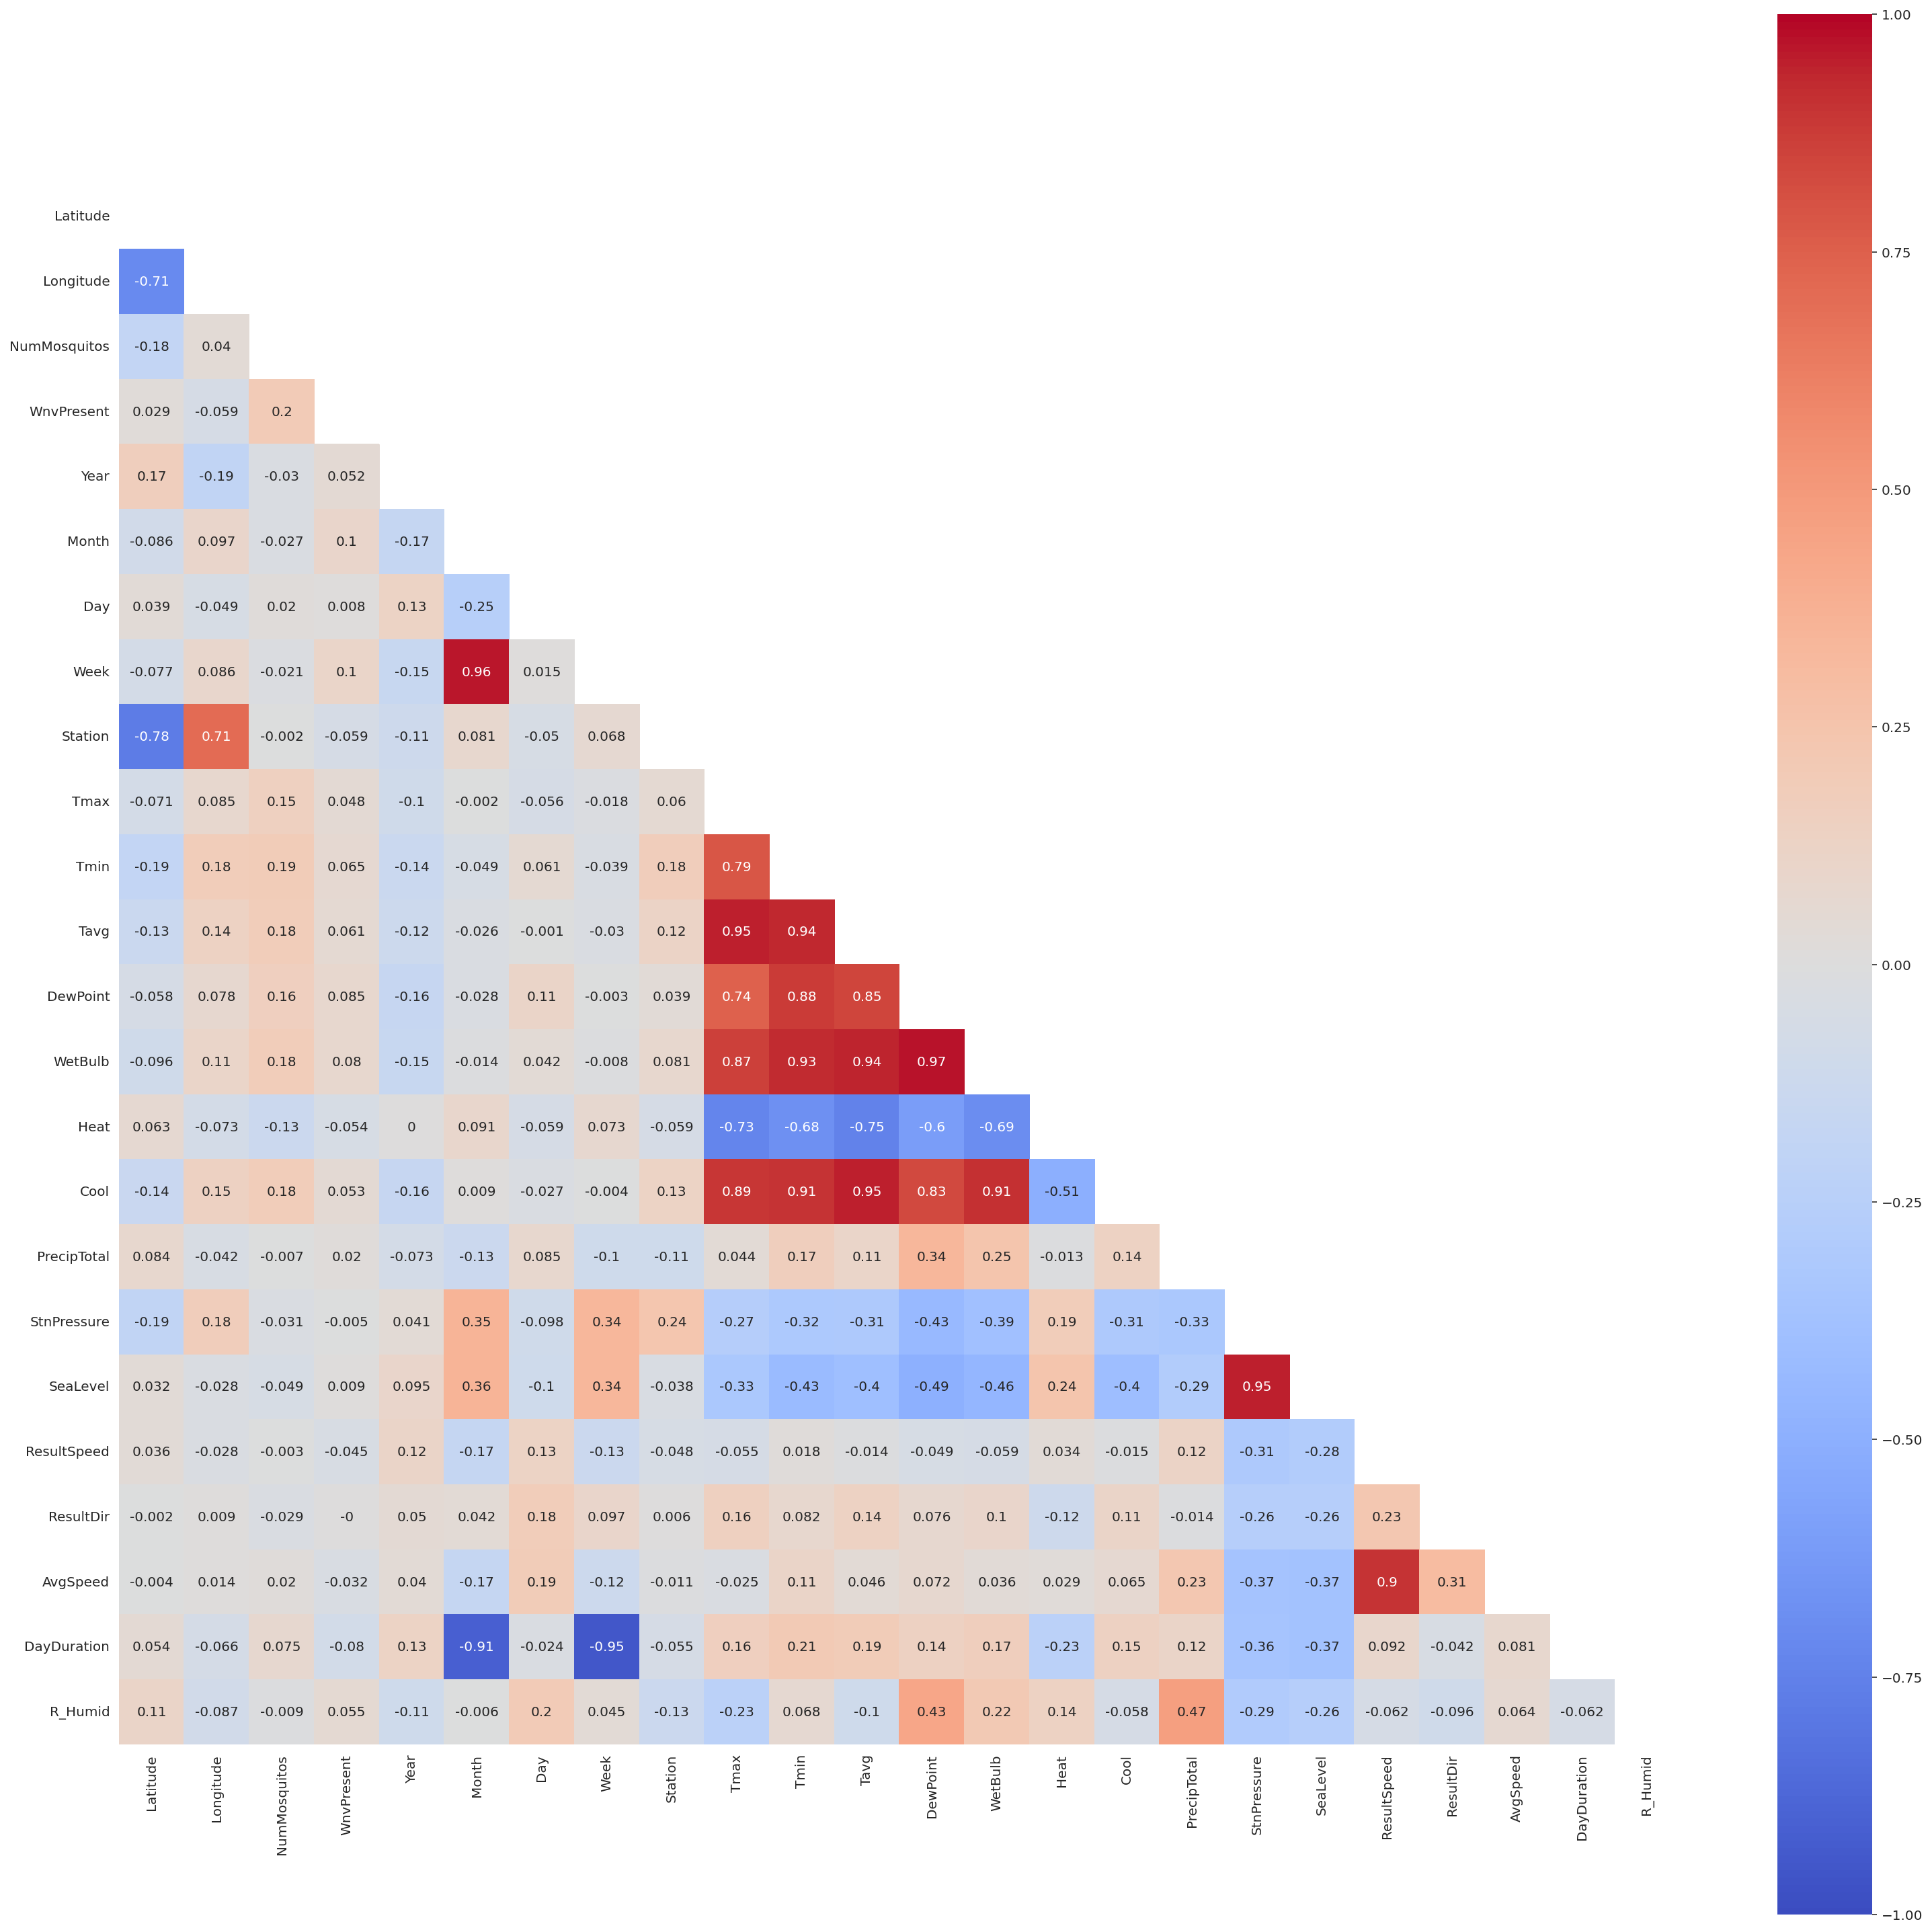

In [30]:
plt.figure(figsize = (26,26))

corr = round(train_merged.corr(), 3)

mask  = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    
    sns.heatmap(corr, mask = mask, 
                square = True, 
                vmin = -1, 
                vmax = 1, 
                cmap = "coolwarm", 
                annot = True)

Based on the Heatmap above, the columns to drop to avoid multicollinearity are: Tmax, Tmin, WetBulb, ResultSpeed, ResultDir, Sealevel.

Tmax and Tmin have high correlation with Tavg as expected. Since Tavg is the average of Tmax and Tmin, it is kept for modelling while Tmax and Tmin are drop.

WetBulb and DewPoint are highly correlated at 0.97. This is as expected since WetBulb and Dewpoint are quite similar. WetBulb is drop instead due to DewPoint having a higher correlation (0.086) with Wnvpresent as compared with WetBulb (0.081).

AvgSpeed is highly correlated with ResultSpeed at 0.9. Likewise with Tavg, the average is kept. Thus, ResultSpeed is drop. In that, ResultDir is drop as well since it is only useful with ResultSpeed.

Lastly, SeaLevel is highly correlated with StnPressure at 0.94. Likewise with WetBulb, SeaLevel is drop instead due to StnPressure having a higher correlation (0.008) with Wnvpresent as compared with SeaLevel (0.006)

In [31]:
train_merged.drop(columns =['Tmax', 'Tmin','WetBulb','ResultSpeed','ResultDir','SeaLevel'], inplace = True)

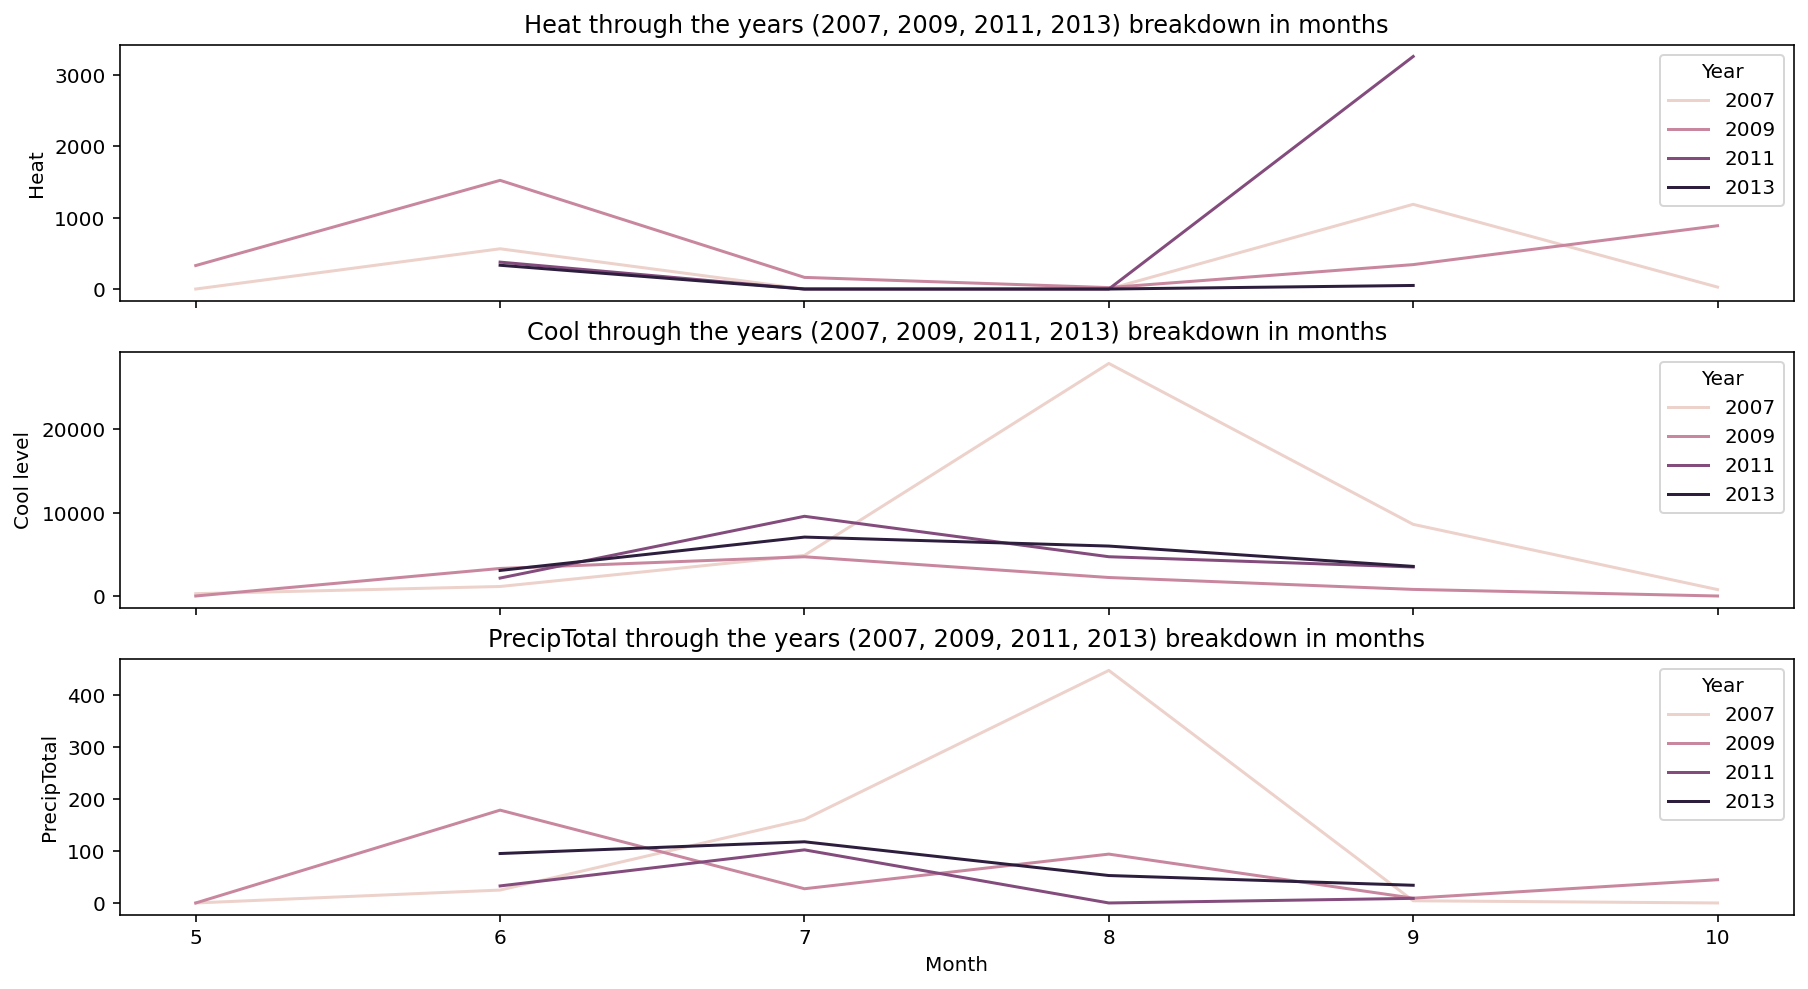

In [32]:
# plot mosquitos/ WnvPresent count by month and year
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, sharey=False, figsize=(15,8))
axes=axes.ravel()

# plot heat by year breakdown in months
sns.lineplot(x='Month', 
             y='Heat',
             hue = 'Year',
             ax=axes[0],
             data=train_merged.groupby(by=['Year', 'Month']).sum()[['Heat']],
             ci = None)

axes[1].set_ylabel("Heat level")
axes[0].set_title('Heat through the years (2007, 2009, 2011, 2013) breakdown in months')

# plot cool by year breakdown in months
sns.lineplot(x='Month', 
             y='Cool',
             hue='Year', 
             data=train_merged.groupby(by=['Year', 'Month']).sum()[['Cool']],
             ax=axes[1],
             ci = None)
axes[1].set_ylabel("Cool level")
axes[1].set_title('Cool through the years (2007, 2009, 2011, 2013) breakdown in months')

# plot PrecipTotal by year breakdown in months
sns.lineplot(x='Month', 
             y='PrecipTotal',
             hue='Year', 
             data=train_merged.groupby(by=['Year', 'Month']).sum()[['PrecipTotal']],
             ax=axes[2],
             ci = None)
axes[2].set_ylabel("PrecipTotal")
axes[2].set_title('PrecipTotal through the years (2007, 2009, 2011, 2013) breakdown in months')

plt.show()

From the plots. it can be seen that rain level and cool level increases sharply from July to August. Heat level increases from August onwards. We will investigate further on the weather effects on the mosquito counts and WNV Present.

**Heat Level**

Is a measurement called heating degree day (HDD) designed to quantify the demand for energy needed to heat a building. It is the number of degrees that a day's average temperature is below 65o Fahrenheit (18o Celsius), which is the temperature below which buildings need to be heated. ([*source*](https://www.investopedia.com/terms/h/heatingdegreeday.asp))

In [33]:
# Create weather analysis dataframe
weather_analysis_df = train_merged.set_index('Date').copy()
weather_analysis_df=weather_analysis_df.groupby('Date').mean()

In [34]:
# Plot timeseries of NumMosquitos and weather feature
def plot_weather(column):
    fig, ax = plt.subplots(ncols=1, nrows=4, figsize=(15,20), sharey=True)
    ax=ax.ravel()

    for i, yr in enumerate([2007, 2009, 2011, 2013]):
        ax[i].set_title('Number of Mosquito and ' + column + ' ' + str(yr))
        sns.lineplot(x=mos_dist_df.loc[str(yr)].index,
                     y=mos_dist_df.loc[str(yr)]['NumMosquitos'].rolling(5, center=True).mean(),
                     ax=ax[i], 
                     label='NumMosquitos',
                     color='blue')
        ax2=ax[i].twinx()
        sns.lineplot(x=weather_analysis_df.loc[str(yr)].index,
                     y=weather_analysis_df.loc[str(yr)][column].rolling(5, center=True).mean(), 
                     ax=ax2,
                     label=column,
                     color='orange')
        # ax2.set_ylim([0, 50])
        ax[i].legend(loc='upper left')
        ax2.legend(loc='upper right')
    plt.tight_layout()

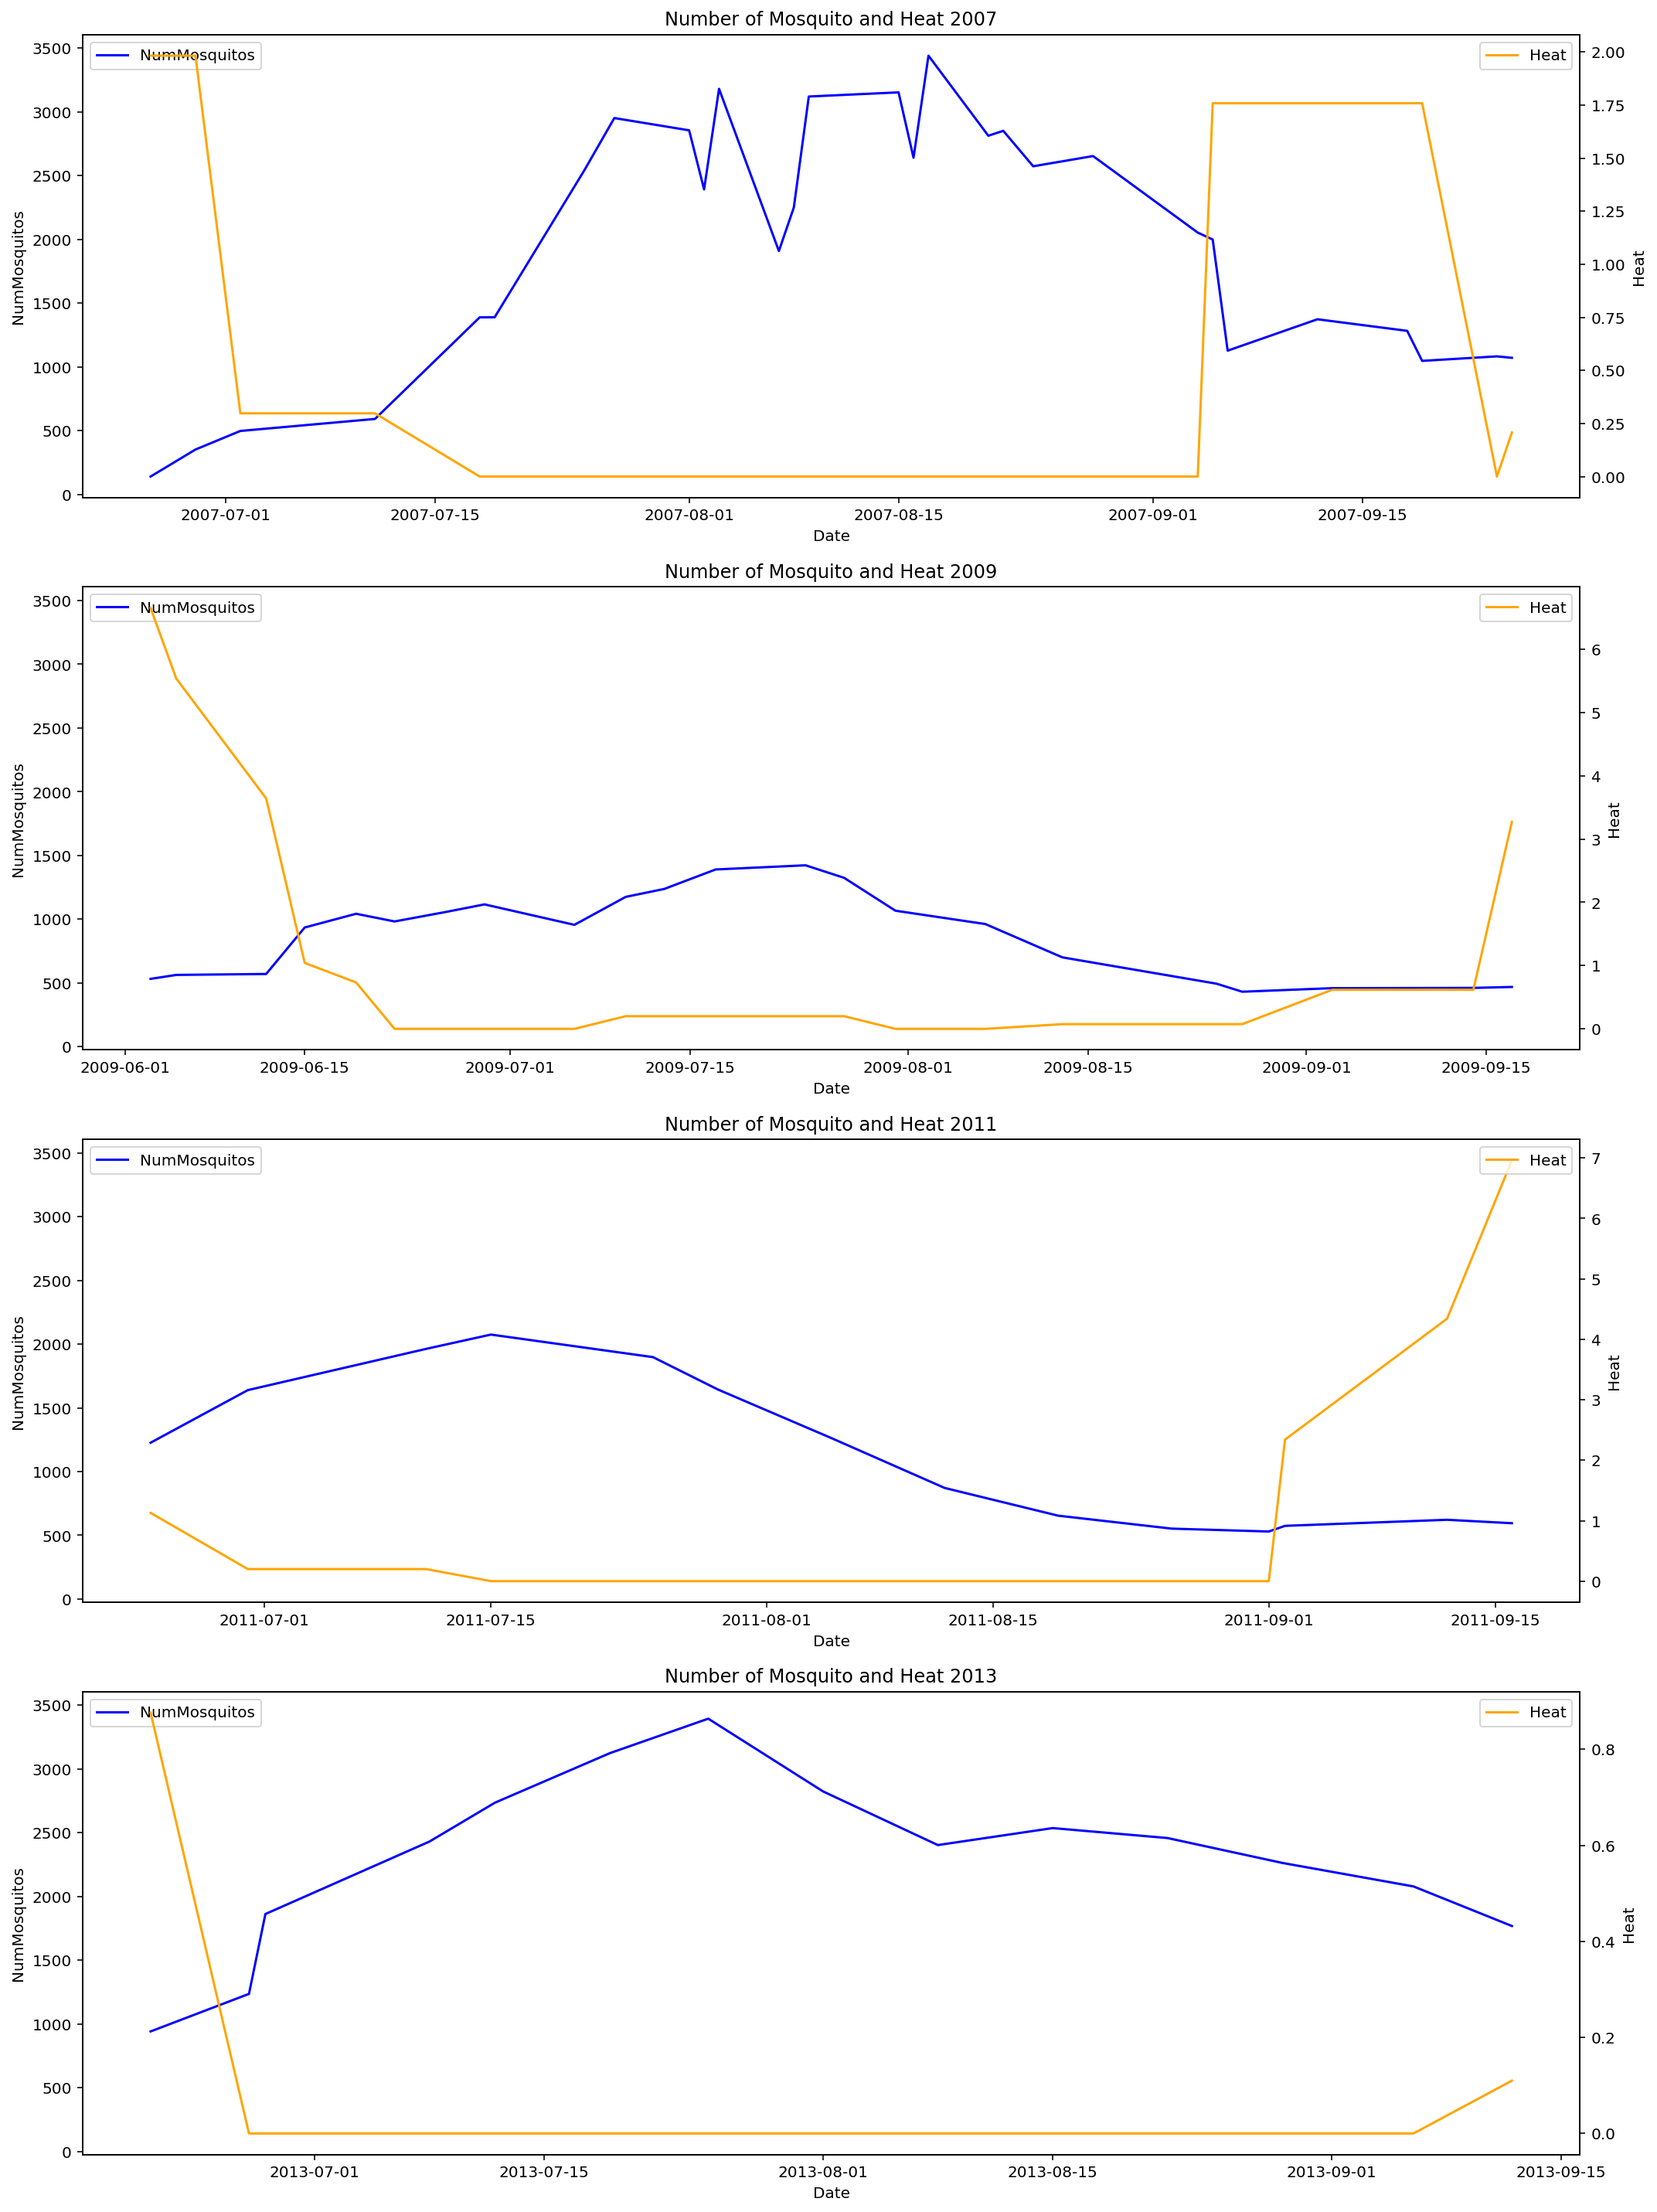

In [35]:
# Plot NumMosquitos and Heat
plot_weather('Heat')

1. Heat level is inversely related to number of mosquitos. High heat level will result in lower mosquitos count, which will reduce the number of WNV present.
2. The low heat level in early July stimulates the breeding of mosquitos. 

**Cool Level**

Is a measurement called cooling degree day (CDD)  designed to quantify the demand for energy needed to cool buildings. It is the number of degrees that a day's average temperature is above 65o Fahrenheit (18o Celsius). Studies have shown that when the outside temperature reaches that level, people inside no longer want the building heated, but instead begin to consider cooling the building.([*source*](https://www.investopedia.com/terms/c/colddegreeday.asp))

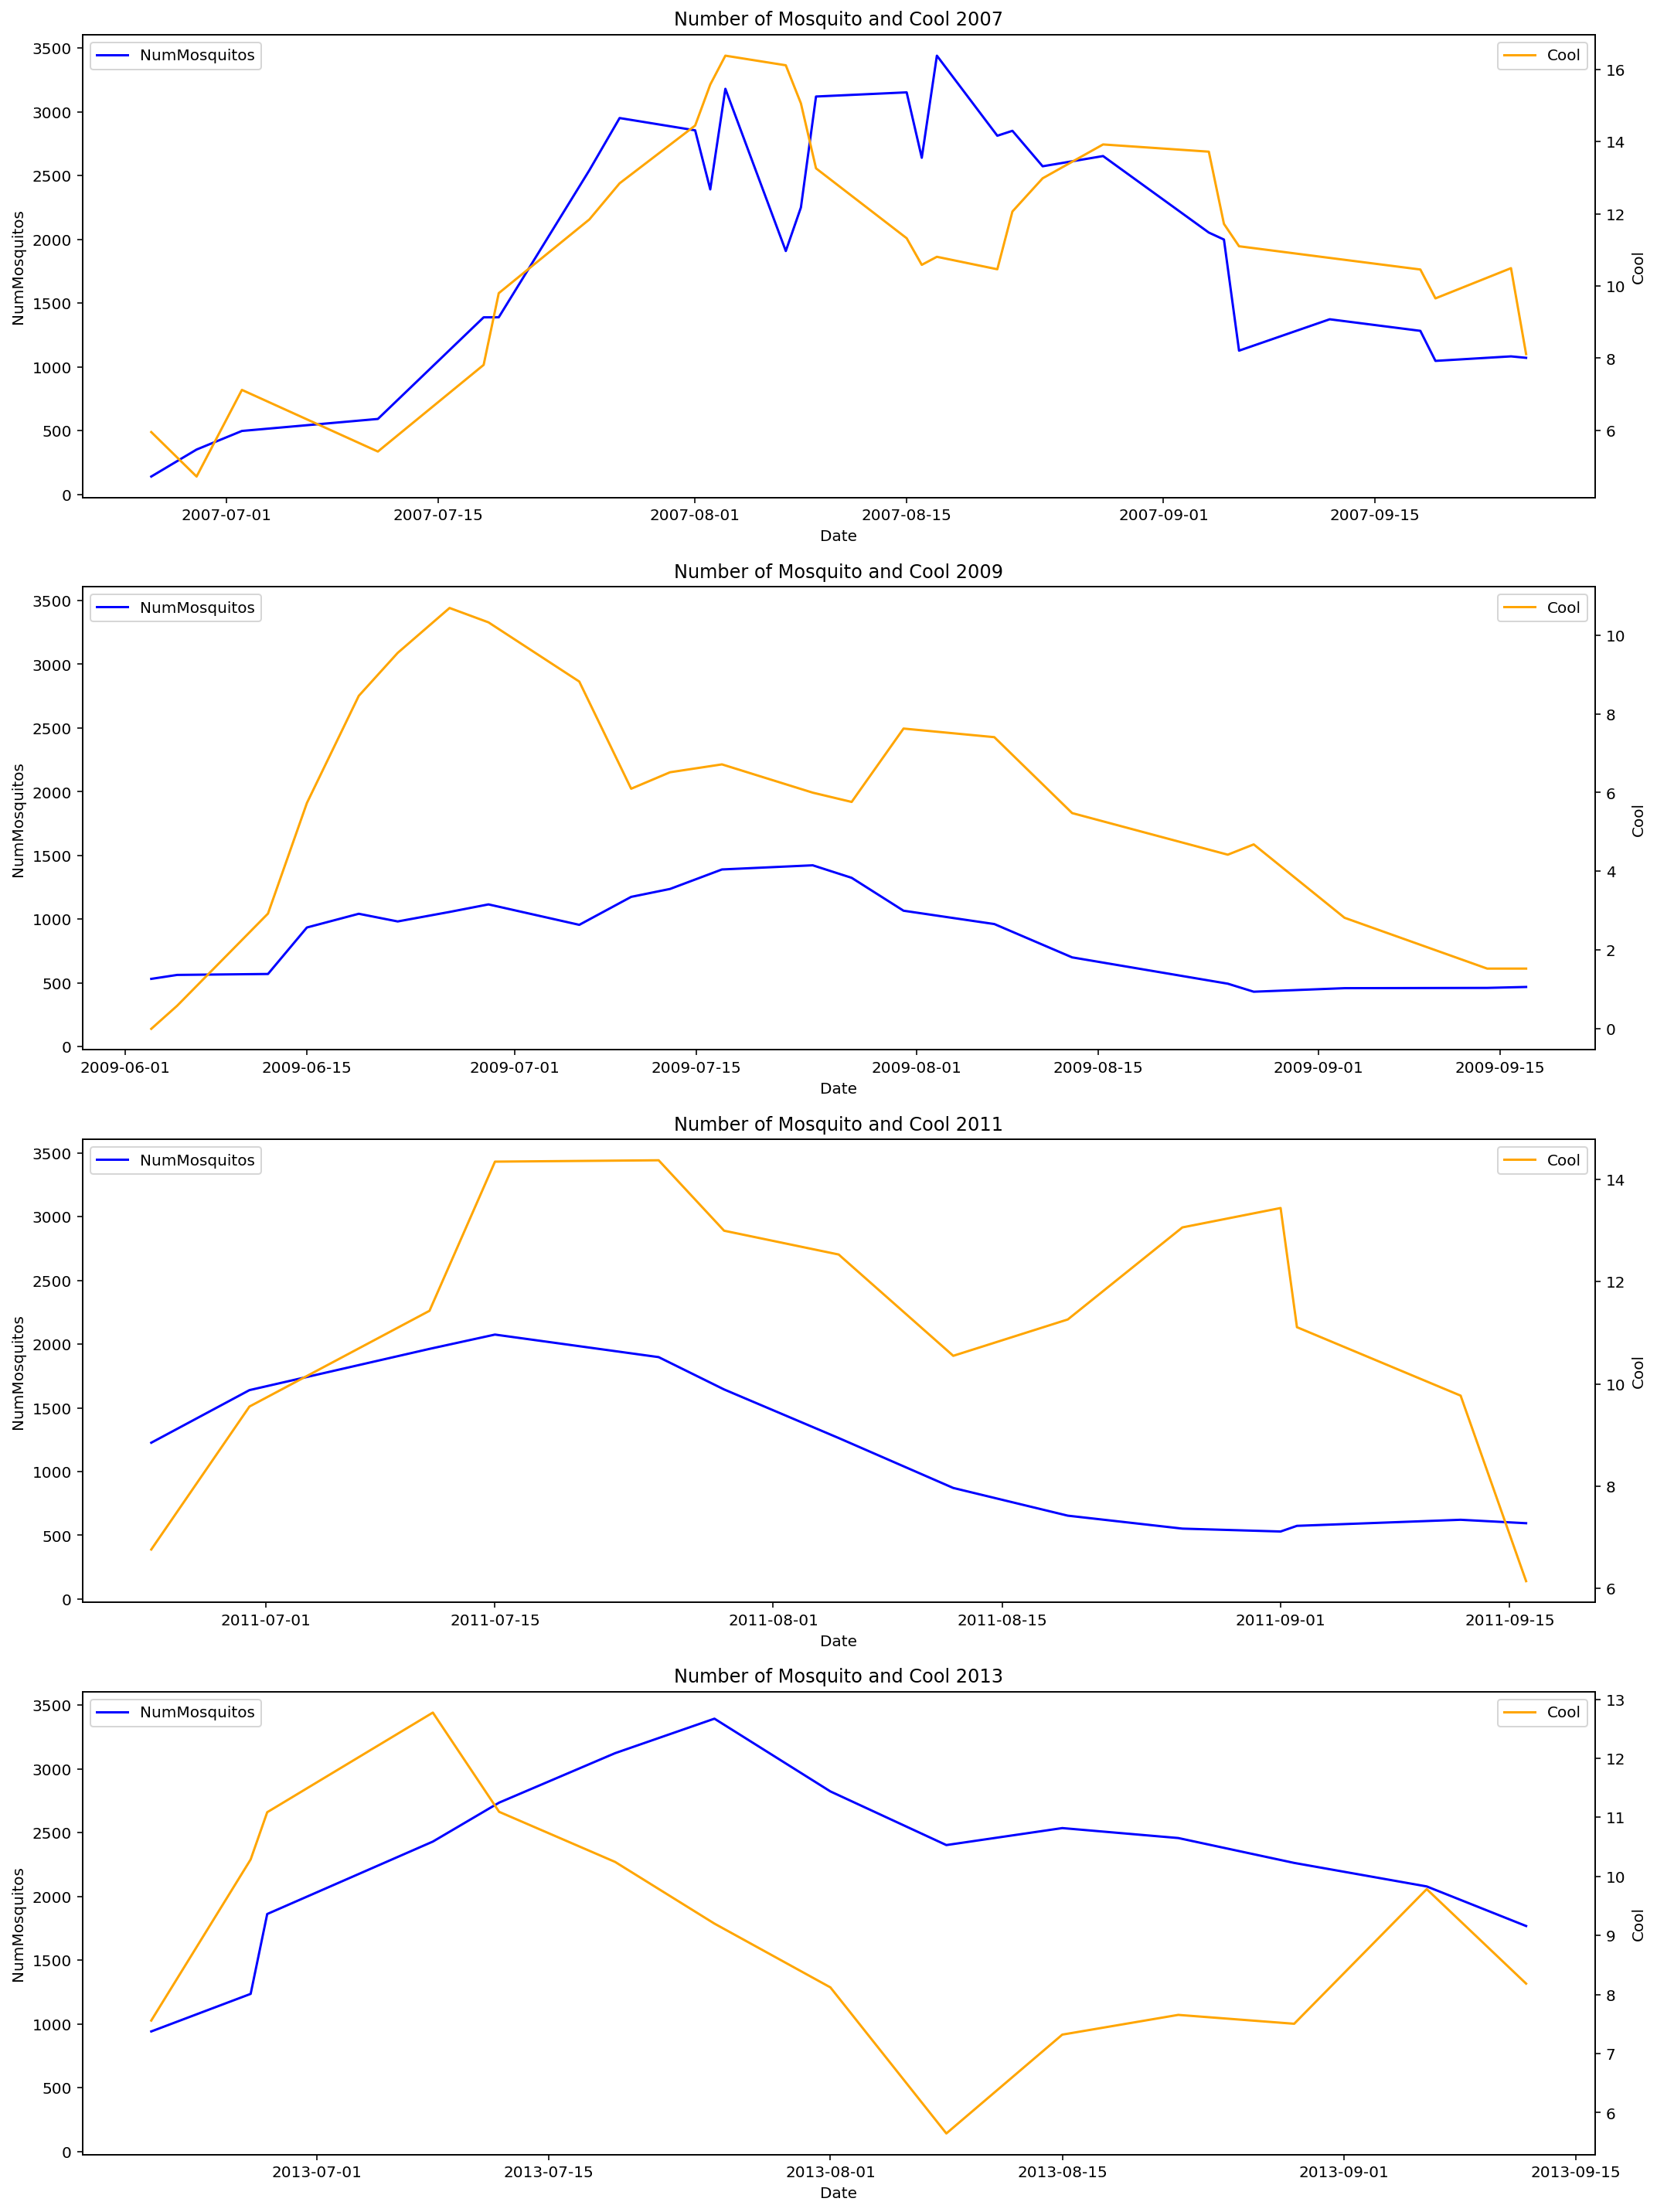

In [36]:
# Plot NumMosquitos and Cool
plot_weather('Cool')

1. Cool level is directly related to number of mosquitos. High cool level will result in high mosquitos count, which will increase the number of WNV present.
2. The high cool level in early July stimulates the breeding of mosquitos. 

**PrecipTotal**

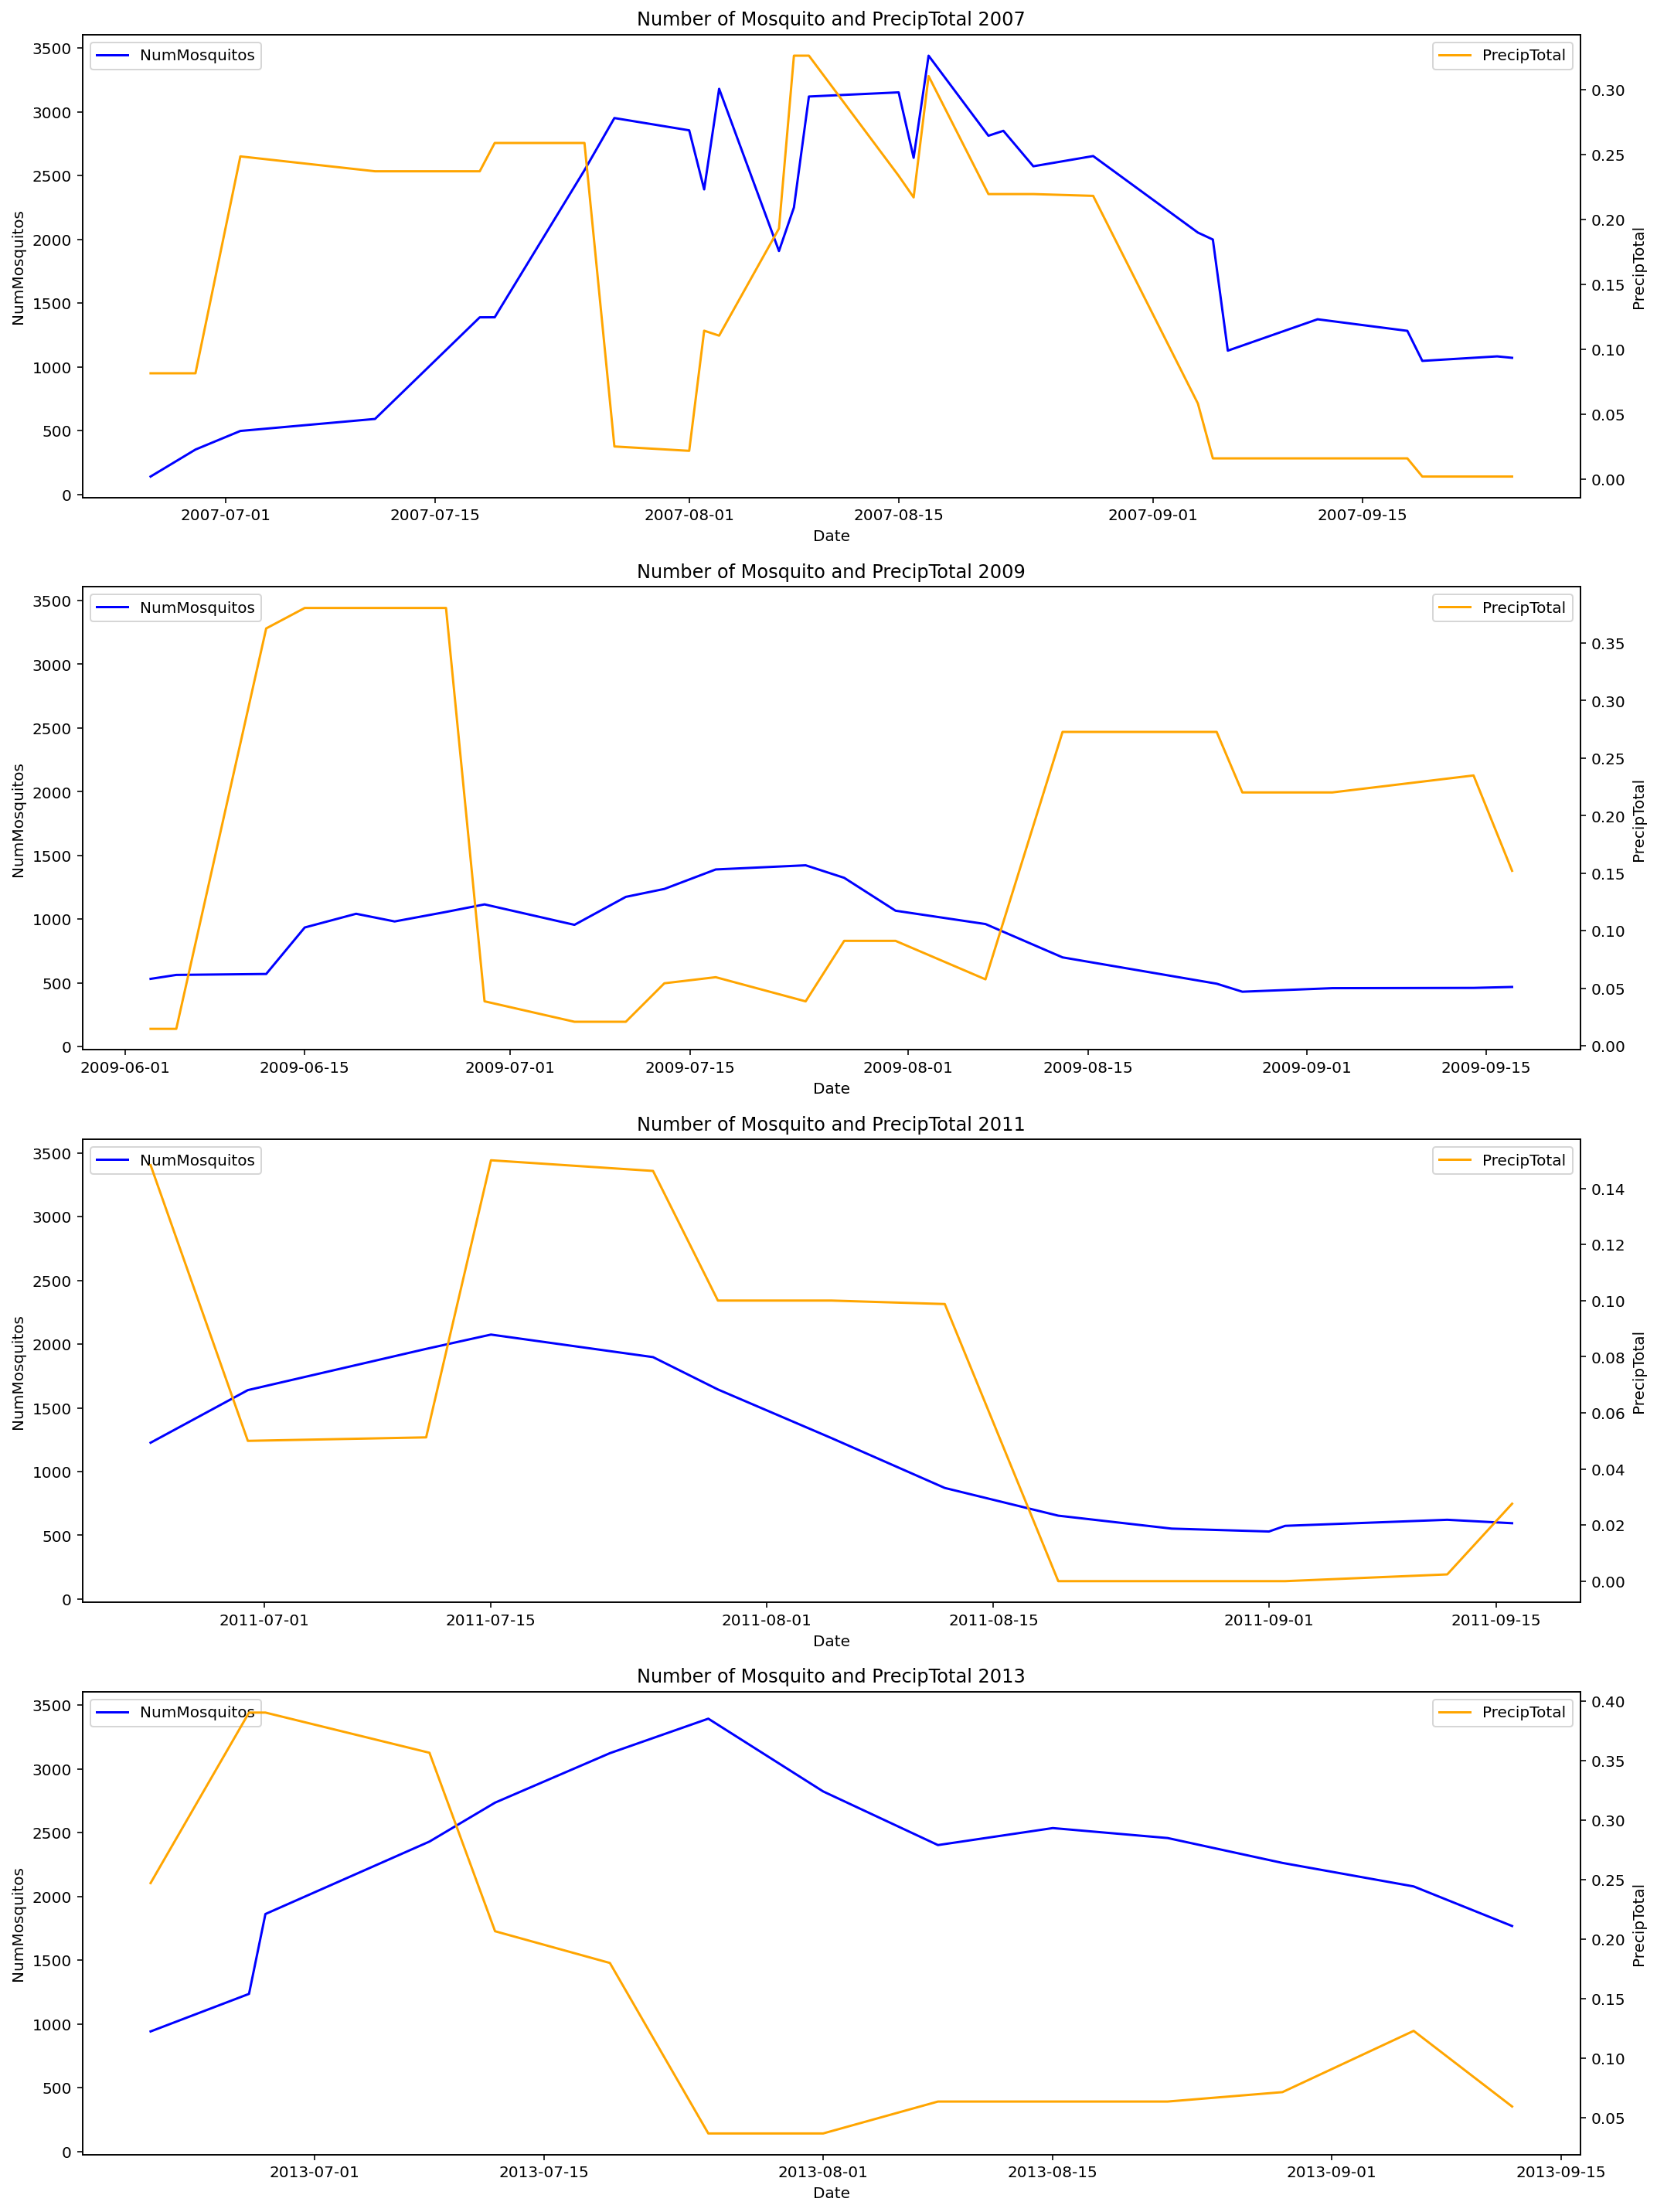

In [37]:
# Plot NumMosquitos and PrecipTotal
plot_weather('PrecipTotal')

1. PrecipTotal has significant direct effect on number of mosquitos. High PrecipTotal will result in high mosquitos count, which will increase the number of WNV present.
2. In 2007 and 2013, the PrecipTotal is generally higher in early July. This stimulate the breeding of WNV carrying mosquitos. 
3. Hence, this explains the higher number of traps with WNV present. 
4. Mitigations should be implemented when there is high PrecipTotal and cool level starts to increase. 

**DayDuration**

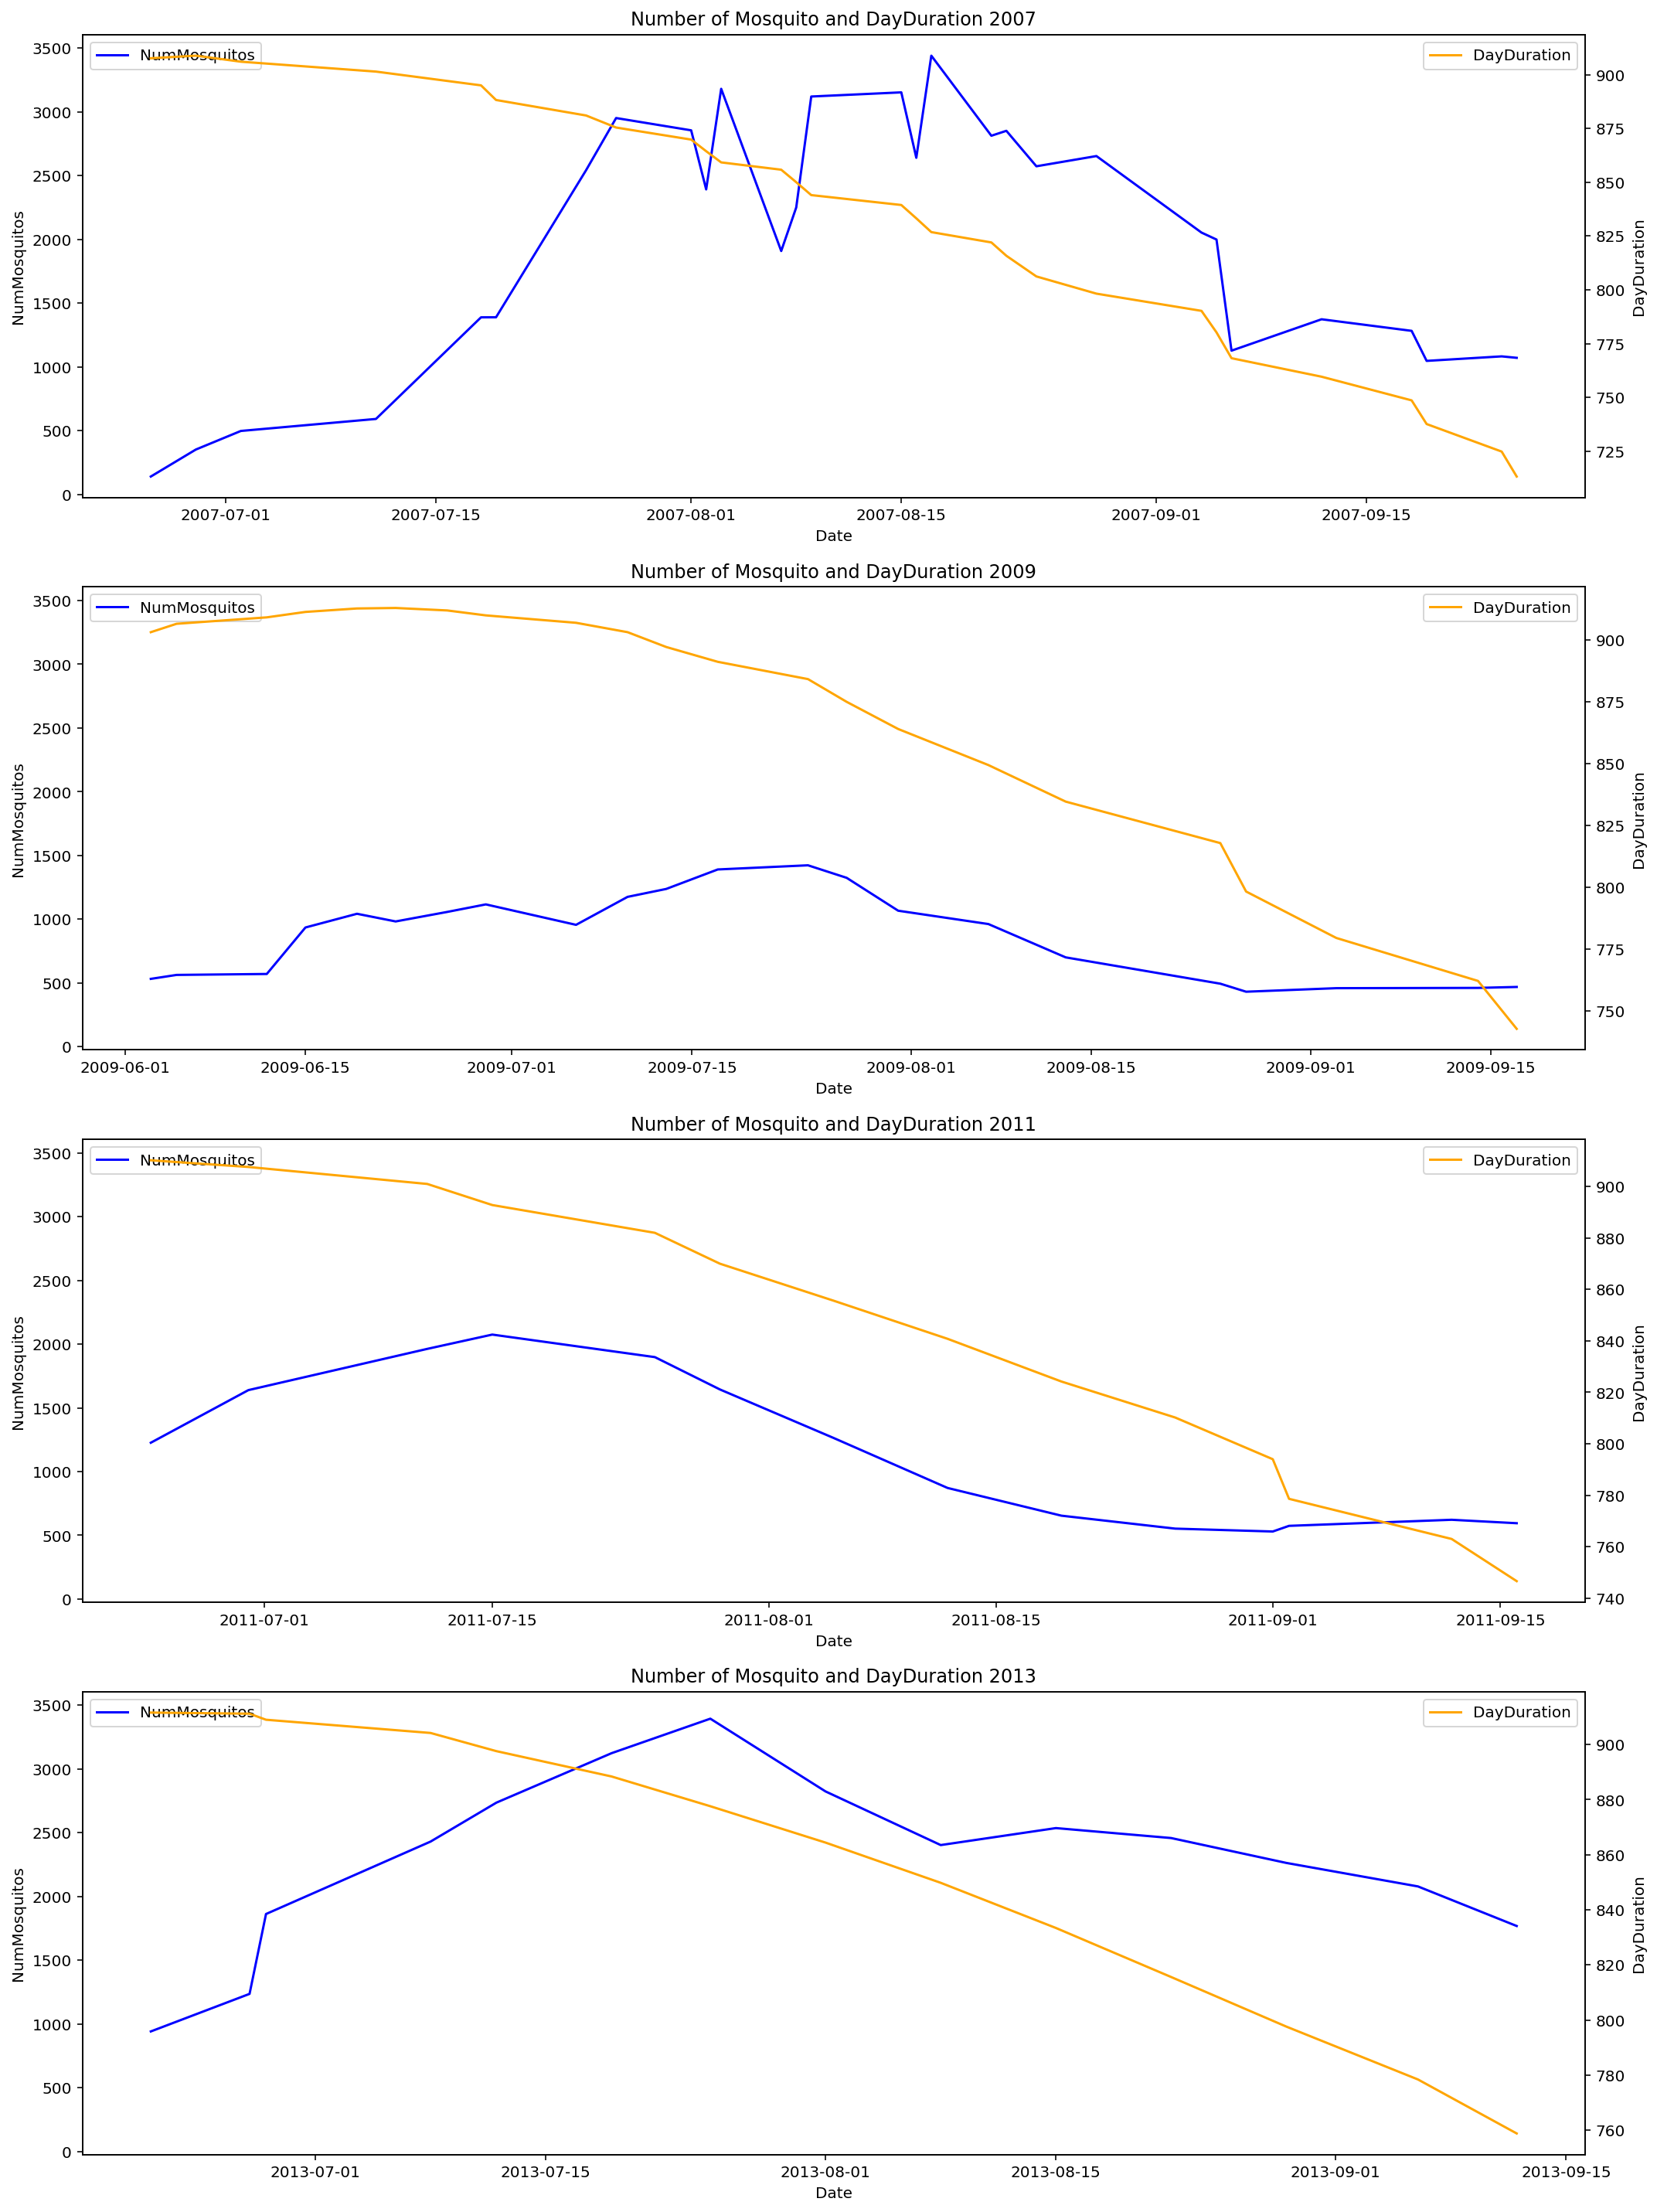

In [38]:
# Plot NumMosquitos and DayDuration
plot_weather('DayDuration')

1. There is no explicit relationship between the number of DayDuration and Mosquito population.
2. However, it is expected that the shorter the dayduration, the longer mosquito feeding time during the dark hours, resulting in an increase risk of  transmission WNV due to mosquito bite.

### Spray Data Analysis

In [39]:
# Prepare dataframe to plot spray data
spray_df['Year'] = spray_df['Date'].dt.year
spray_2011 = spray_df.loc[spray_df['Year']==2011]
spray_2013 = spray_df.loc[spray_df['Year']==2013]
#spray_filtered.drop(['year'], axis=1, inplace=True)

In [40]:
# Display dates of spraying
spray_dates = pd.DataFrame(spray_df[["Date"]].value_counts().sort_index(), 
                           columns=['SprayCount'])
spray_dates=spray_dates.reset_index()
spray_dates


Date  SprayCount
0 2011-09-07         989
1 2013-07-17        2202
2 2013-07-25        1607
3 2013-08-08        1195
4 2013-08-15        2668
5 2013-08-16         141
6 2013-08-22        1587
7 2013-08-29        2302
8 2013-09-05         924

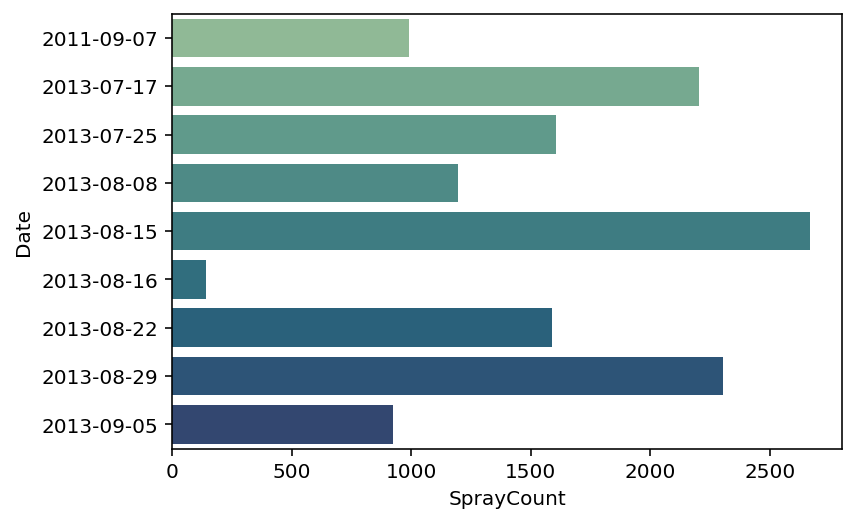

In [41]:
# Plot dates of spraying
ax=sns.barplot(data=spray_dates,
               y ='Date',
               x='SprayCount', 
               orient='horizontal', 
               palette='crest');

x_dates = spray_dates.Date.dt.strftime('%Y-%m-%d')
ax.set_yticklabels(labels=x_dates, ha='right');

In [42]:
spray_df.groupby(by=['Year','Month', 'Day']).sum()[['Spray Count']]

Spray Count
Year Month Day             
2011 9     7            989
2013 7     17          2202
           25          1607
     8     8           1195
           15          2668
           16           141
           22          1587
           29          2302
     9     5            924

In [43]:
# Display Spray area by year on map

# Create sub plots.
fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(15,50))
axes=axes.ravel()

# Plot spray and mosquito data in Sep 2011
axes[0].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_boundary, aspect=aspect)

axes[0].scatter(spray_2011['Longitude'], spray_2011['Latitude'], 
                      c='yellow', marker='o', s=20, alpha=0.8, label ='Spray on 2011-09-07')

axes[0].scatter(data=no_wnv[(no_wnv['Date']>pd.to_datetime('2011-09-15'))
                            & (no_wnv['Date']<pd.to_datetime('2011-09-22'))],
                x='Longitude', 
                y='Latitude', 
                c="blue", 
                s=10, 
                alpha=1, 
                label='Without Nile Virus between 2011-09-15 and 2011-09-22')

axes[0].scatter(data=wnv[(wnv['Date']>pd.to_datetime('2011-09-15'))
                         & (wnv['Date']<pd.to_datetime('2011-09-22'))],
                x='Longitude', 
                y='Latitude', 
                c="red", 
                s=5, 
                alpha=1, 
                label='With Nile Virus between 2011-09-15 and 2011-09-22')

axes[0].set_title('No WNV Present in spray area for a week, 1 week after spray')
axes[0].legend()

# Plot spray and mosquito data in 2013
for i, day in enumerate(spray_dates.Date.dt.strftime('%Y-%m-%d')):
  
  if i>0:

    start = pd.to_datetime(day) + dt.timedelta(days=8)
    start = start.strftime("%m/%d/%Y")
    end = pd.to_datetime(day) + dt.timedelta(days=15)
    end = end.strftime("%m/%d/%Y")

    # Plot spray and mosquito data based on spray date
    axes[i].imshow(mapdata, cmap=plt.get_cmap('gray'), extent=lon_lat_boundary, aspect=aspect)

    axes[i].scatter(data=spray_2013[spray_2013['Date']==day],
                    x='Longitude', 
                    y='Latitude',  
                    c='yellow', marker='o', s=5, alpha=0.8, 
                    label='Spray on '+str(day))

    axes[i].scatter(data=no_wnv[(no_wnv['Date']>start)
                                & (no_wnv['Date']<end)],
                    x='Longitude', 
                    y='Latitude', 
                    c="blue", 
                    s=10, 
                    alpha=1, 
                    label='Without Nile Virus between '+str(start)+' and ' +str(end))

    axes[i].scatter(data=wnv[(wnv['Date']>start)
                            & (wnv['Date']<end)],
                    x='Longitude', 
                    y='Latitude', 
                    c="red", 
                    s=5, 
                    alpha=1, 
                    label='With Nile Virus between '+str(start)+' and ' +str(end))

    # axes[1].set_title('Sep 2013')
    axes[i].legend()

axes[1].set_title('No WNV Present Data for Analysis, 1 week after spray')
axes[2].set_title('No WNV Present in spray area for a week, 1 week after spray')
axes[3].set_title('No WNV Present in spray area for a week, 1 week after spray')
axes[4].set_title('No WNV Present in spray area for a week, 1 week after spray')
axes[5].set_title('No WNV Present in spray area for a week, 1 week after spray')
axes[6].set_title('No WNV Present Data for Analysis, 1 week after spray')
axes[7].set_title('WNV Present Data for Analysis, 1 week after spray')
axes[8].set_title('No WNV Present in spray area for a week, 1 week after spray')
plt.show();

Output hidden; open in https://colab.research.google.com to view.

In [44]:
# Create dataframe of trap latitude longitude.
trap_loc_2011 = train_merged[train_merged['Year']==2011][['Trap','Latitude', 'Longitude']].drop_duplicates()
trap_loc_2013 = train_merged[train_merged['Year']==2013][['Trap','Latitude', 'Longitude']].drop_duplicates()
trap_loc_2011.head()

Trap   Latitude  Longitude
6012  T049  41.896282 -87.655232
6013  T094  41.720848 -87.666014
6014  T148  42.017430 -87.687769
6015  T028  41.986921 -87.689778
6016  T031  41.801498 -87.763416

In [45]:
# Find trap in spray area on 2011-09-07
trap_loc_2011[(trap_loc_2011['Latitude'].between(41.96, 41.98))
               & (trap_loc_2011['Longitude'].between(-87.83, -87.8))]

Trap   Latitude  Longitude
6070  T223  41.973845 -87.805059

In [46]:
# Create dictionary to store trap info. 
trap_dict={}
trap_dict['2011-09-07']=[['T223'], '2011']

In [47]:
# Find max and min latitude and longitude for spray area on 2013-07-25
spray_2013[spray_2013['Date']=='2013-07-25'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  1607.000000  1607.000000
mean     41.954535   -87.722879
std       0.008333     0.008531
min      41.939308   -87.739840
25%      41.947379   -87.730314
50%      41.955607   -87.722537
75%      41.961917   -87.715814
max      41.968097   -87.707987

In [48]:
# Find trap in spray area on 2013-07-25
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.939308, 41.968097))
               & (trap_loc_2013['Longitude'].between(-87.739840, -87.707987))]

Trap   Latitude  Longitude
8113  T228  41.951866 -87.725057

In [49]:
# Store trap info. 
trap_dict['2013-07-25']=[['T228'], '2013']

In [50]:
# Find max and min latitude and longitude for spray area on 2013-08-08
spray_2013[spray_2013['Date']=='2013-08-08'][['Latitude', 'Longitude']].describe()

Latitude    Longitude
count  1195.000000  1195.000000
mean     41.931466   -87.697035
std       0.008555     0.010608
min      41.917227   -87.716847
25%      41.923121   -87.705352
50%      41.931312   -87.695657
75%      41.938589   -87.689037
max      41.946703   -87.678060

In [51]:
# Find trap in spray area on 2013-08-08
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.931466, 41.946703))
               & (trap_loc_2013['Longitude'].between(-87.716847, -87.678060))]

Trap   Latitude  Longitude
8145  T147  41.932094 -87.700117

In [52]:
# Store trap info. 
trap_dict['2013-08-08']=[['T147'], '2013']

In [53]:
# Find trap in spray area on 2013-08-15
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.87, 41.93))
               & (trap_loc_2013['Longitude'].between(-87.80, -87.73))]

Trap   Latitude  Longitude
8062  T013  41.923738 -87.785288
8111  T230  41.904194 -87.756155
8218  T222  41.925198 -87.746381

In [54]:
# Store trap info. 
trap_dict['2013-08-15']=[['T013', 'T230', 'T222'], '2013']

In [55]:
# Find trap in spray area on 2013-08-16
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.95, 41.98))
               & (trap_loc_2013['Longitude'].between(-87.75, -87.72))]

Trap   Latitude  Longitude
8113  T228  41.951866 -87.725057

In [56]:
# Store trap info. 
trap_dict['2013-08-16']=[['T228'], '2013']

In [57]:
# Find trap in spray area on 2013-08-29
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.97, 41.99))
               & (trap_loc_2013['Longitude'].between(-87.70, -87.68))]

Trap   Latitude  Longitude
8048  T028  41.986921 -87.689778

In [58]:
# Find trap in spray area on 2013-08-29
trap_loc_2013[(trap_loc_2013['Latitude'].between(41.76, 41.78))
               & (trap_loc_2013['Longitude'].between(-87.71, -87.69))]

Trap  Latitude  Longitude
8070  T066  41.77166 -87.703047

In [59]:
# Store trap info. 
trap_dict['2013-08-29']=[['T028', 'T066'], '2013']

In [60]:
# Find trap in spray area on 2013-09-05
trap_loc_2013[(trap_loc_2013['Latitude'].between(42.00, 42.02))
               & (trap_loc_2013['Longitude'].between(-87.81, -87.79))]

Trap   Latitude  Longitude
8116  T233  42.009876 -87.807277

In [61]:
# Store trap info. 
trap_dict['2013-09-05']=[['T233'], '2013']

In [62]:
# Display trap_dict
trap_dict

{'2011-09-07': [['T223'], '2011'],
 '2013-07-25': [['T228'], '2013'],
 '2013-08-08': [['T147'], '2013'],
 '2013-08-15': [['T013', 'T230', 'T222'], '2013'],
 '2013-08-16': [['T228'], '2013'],
 '2013-08-29': [['T028', 'T066'], '2013'],
 '2013-09-05': [['T233'], '2013']}

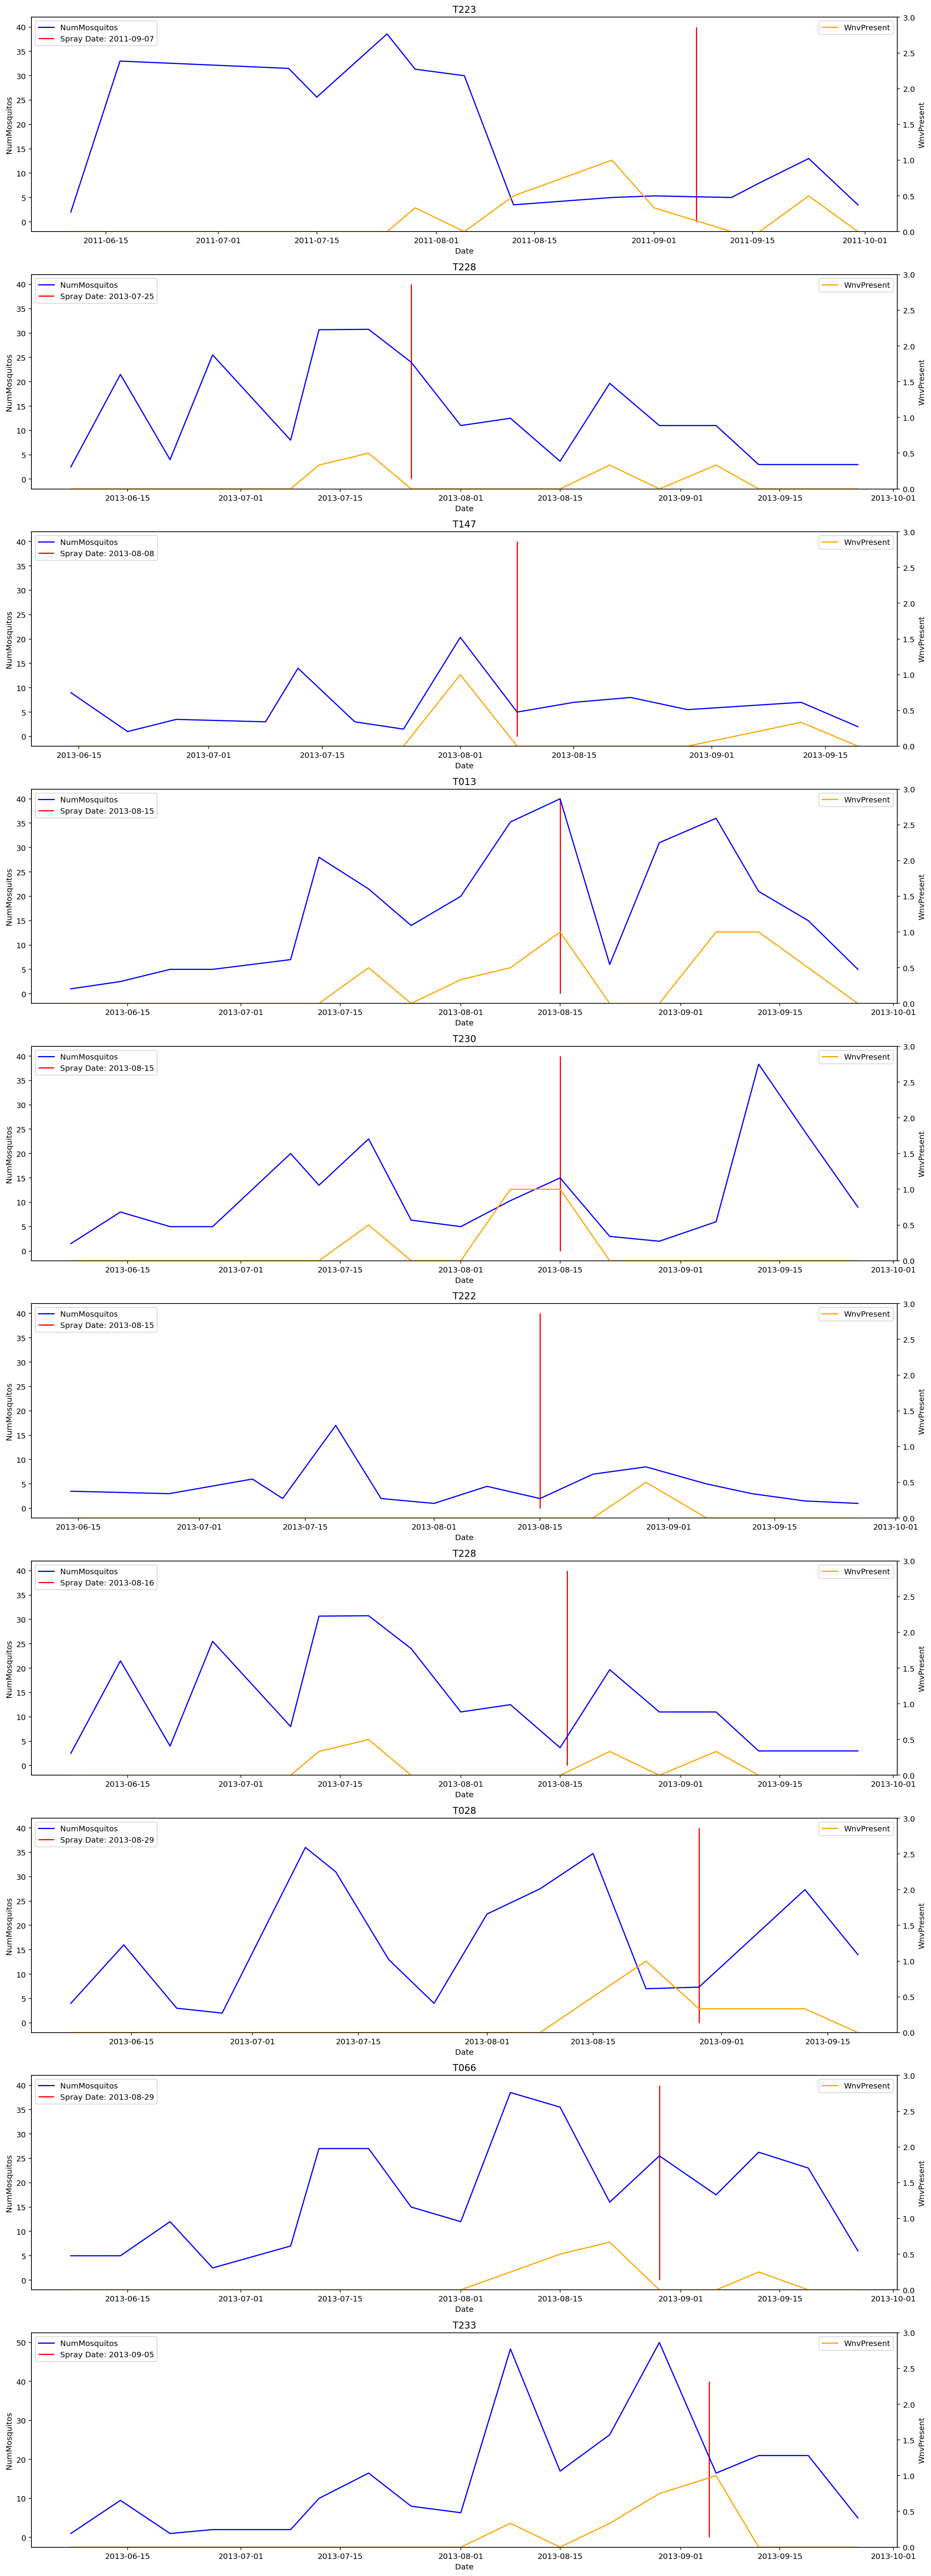

In [63]:
# plot mosquitos/ WnvPresent count by month and year for sprayed traps
fig, axes = plt.subplots(nrows=10, ncols=1, sharex=False, sharey=False, figsize=(20,60))
axes=axes.ravel()


i=0

for date, value in trap_dict.items():
    
    for j in range(len(value[0])):

        # Plot NumMosquitos
        sns.lineplot(x=train_merged[(train_merged['Year']==int(value[1])) & (train_merged['Trap']==value[0][j])]['Date'],
                     y=train_merged[(train_merged['Year']==int(value[1])) & (train_merged['Trap']==value[0][j])]['NumMosquitos'], 
                     ax=axes[i],
                     ci=False,
                     color='blue', 
                     label='NumMosquitos');

        ax2=axes[i].twinx()
        ax2.set_ylim([0, 3])

        # Plot WnvPresent
        sns.lineplot(x=train_merged[(train_merged['Year']==int(value[1])) & (train_merged['Trap']==value[0][j])]['Date'],
                     y=train_merged[(train_merged['Year']==int(value[1])) & (train_merged['Trap']==value[0][j])]['WnvPresent'], 
                     ax=ax2,
                     ci=False,
                     color='orange', 
                     label='WnvPresent');
        
        # Indicate Spray Date 
        axes[i].vlines(x=pd.to_datetime(date),
                       ymin=0,
                       ymax=40,
                       color='red',
                       label='Spray Date: ' + date);
        
        axes[i].set_title(value[0][j])
        axes[i].legend(loc='upper left');
    
        i+=1


1. Based on the mosquitos count and WNV presence plot of various traps, it is observed spraying is effective in reducing the number of mosquitos and directly decreases the number of WNV presence.
2. However, the effect of spraying lasts about two weeks. 
3. From the weather data analysis, it was observed that the number of WNV carrying mosquitos starts increasing in early Jul, spraying conducted in end Jul and Aug seems to be reactive instead of pre-emptive. 
4. Hence, if spraying needed to be done, it should be conducted in Jul when the PrecipTotal is high and Cool level starts increasing to prevent the breeding of mosquitos. 


## Save Data

In [64]:
# Save Train/Test merged and spray dataset
train_merged.to_csv(f'{PATH}data/part2_train_merged.csv', index=False)
test_merged.to_csv(f'{PATH}data/part2_test_merged.csv', index=False)

# <center> **End of Notebook**